## Correlacion de pearson sobre la variable GASTOT

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
def load_datalake_data(output_dir="../../DataLake"):
    """
    Carga los datos del DataLake y los fusiona correctamente.
    """
    all_data = []
    
    for year in os.listdir(output_dir):
        year_path = os.path.join(output_dir, year)
        if os.path.isdir(year_path):
            file_comunidad = os.path.join(year_path, "external_indicators.tsv")
            file_hogares = os.path.join(year_path, "homes.tsv")
            
            if os.path.exists(file_comunidad) and os.path.exists(file_hogares):
                df_comunidad = pd.read_csv(file_comunidad, sep="\t")
                df_hogares = pd.read_csv(file_hogares, sep="\t")
                
                # Agregar la columna de año
                df_comunidad["Año"] = year
                df_hogares["Año"] = year

                df_merged = df_hogares.merge(df_comunidad, on="CCAA", how="left")
                
                all_data.append(df_merged)
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()


In [6]:
def compute_correlation(df, target_column="GASTOT"):
    """
    Compute Pearson correlation of numerical variables with a target column,
    adjusting the target column by dividing by factor_x and factor_y.
    """
    if target_column in df.columns:
        df[target_column] = df[target_column] / df["FACTOR"]
        df[target_column] = df[target_column] / 12
        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
        correlation_matrix = df[numeric_columns].corr(method='pearson')
        # Drop the FACTOR column from the correlation matrix
        correlation_matrix = correlation_matrix.drop(columns=["FACTOR", 'NUMERO', 'Comunidad_Autonoma'], errors='ignore')
        return correlation_matrix[target_column].drop(target_column).sort_values(ascending=False)
    else:
        print(f"⚠️ Column '{target_column}' not found in the dataset.")
        return None

def plot_correlation_heatmap(correlation_data, title="Correlation Heatmap"):
    """
    Plot heatmap of the correlation data.
    """
    if correlation_data is not None:
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_data.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
        plt.title(title)
        plt.show()

In [7]:
# Load and process data
df_datalake = load_datalake_data()


In [8]:
pd.set_option('display.max_columns', None)
df_datalake.head()

,NUMERO,CCAA,CAPROV,TAMAMU,DENSIDAD,NUMACTI,NUMOCU,NUMESTU,EDADSP,OCUSP,REGTEN,ZONARES,SUPERF,AGUACALI,CALEF,DISPOSIOV,CAPROP,CAJENA,IMPEXAC,GASTOT,FACTOR,NUMPERI,NACION_ESP,NACION_EXT,EDUC_SUPERIOR,NADUL_FEM,NADUL_MAS,NNINO_FEM,NNINO_MAS,Año_x,Comunidad_Autonoma,Tmax_max,Tmin_min,Tasa_Paro,Inflacion,Tipo_Interes,Año_y
0,1,7,0,1,1,2,2,0,66,1,5,3,96,1,1,0,1,0,1225,14239915.96,742.998897,2,1,0,0,1,1,0,0,2016,Castilla-La Mancha,42.9,-8.0,18.3,1.6,0.0,2016
1,2,12,0,4,3,2,1,0,35,0,6,5,-9,1,1,0,1,1,676,82364853.85,1849.021419,2,1,0,1,1,1,0,0,2016,Galicia,40.3,-4.4,18.2,1.6,0.0,2016
2,3,13,1,5,3,4,4,0,64,1,2,5,155,1,1,0,0,1,5868,95097473.22,1580.183563,4,1,0,0,1,3,0,0,2016,Madrid,35.5,-11.3,16.8,1.4,0.0,2016
3,4,8,0,1,1,4,2,0,60,0,5,1,150,1,1,0,0,1,3769,25251223.53,846.366967,4,1,0,0,2,2,0,0,2016,Castilla y León,39.0,-12.6,25.5,1.6,0.0,2016
4,5,13,0,5,3,1,1,0,37,1,4,5,98,1,1,0,0,1,1271,39117817.76,1359.668063,1,0,1,0,1,1,1,0,2016,Madrid,35.5,-11.3,16.8,1.4,0.0,2016


In [9]:
# Compute correlation
correlation_GASTOT = compute_correlation(df_datalake)

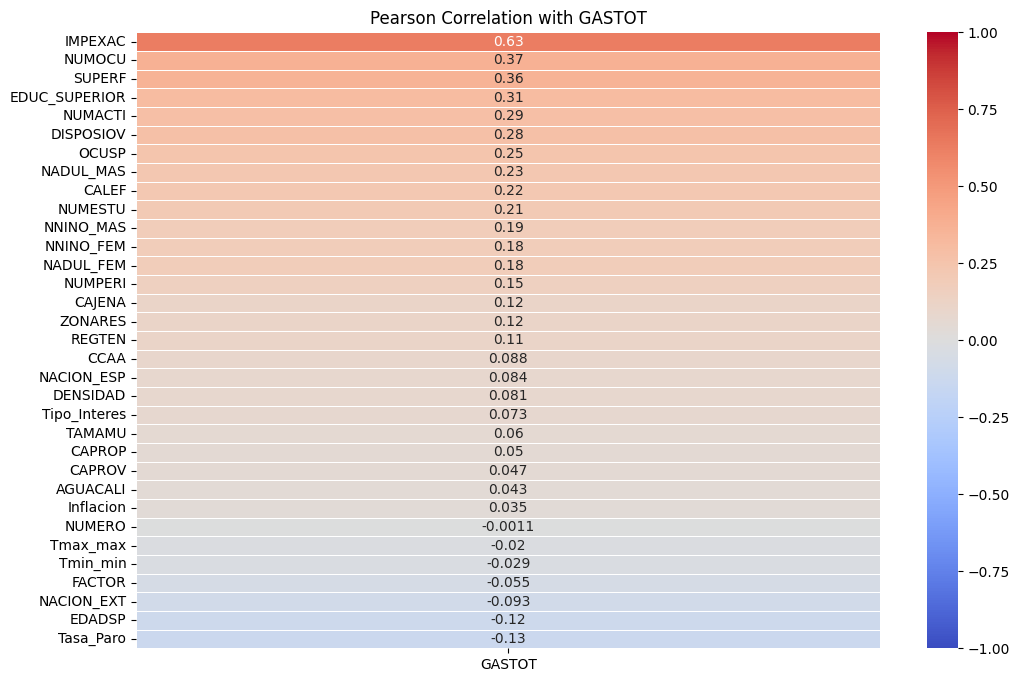

In [10]:
# Plot results
plot_correlation_heatmap(correlation_GASTOT, "Pearson Correlation with GASTOT")

## Analísis Anova

In [11]:
import os
import pandas as pd
import scipy.stats as stats

In [12]:
def perform_anova(df, target_column="GASTOT"):
    """
    Perform ANOVA analysis for categorical variables (including encoded numeric categories) against the target column.
    """
    categorical_columns = df.select_dtypes(include=["object", "category", "int", "int64"]).columns.tolist()
    anova_results = {}
    
    if target_column in df.columns:
        for cat_col in categorical_columns:
            if df[cat_col].nunique() > 1 and df[cat_col].nunique() <= 20:  # Consider only categorical-like numeric columns
                groups = [df[df[cat_col] == category][target_column].dropna() for category in df[cat_col].unique()]
                if len(groups) > 1:
                    f_stat, p_value = stats.f_oneway(*groups)
                    anova_results[cat_col] = p_value
    
    return pd.Series(anova_results).sort_values()

In [13]:
def plot_anova_boxplots(df, target_column="GASTOT"):
    """
    Plot boxplots for categorical variables with respect to the target column.
    """
    categorical_columns = df.select_dtypes(include=["object", "category", "int", "int64"]).columns.tolist()
    categorical_columns = [col for col in categorical_columns if df[col].nunique() > 1 and df[col].nunique() <= 10]
    
    if categorical_columns:
        plt.figure(figsize=(12, len(categorical_columns) * 4))
        for i, cat_col in enumerate(categorical_columns, 1):
            plt.subplot(len(categorical_columns), 1, i)
            sns.boxplot(x=df[cat_col], y=df[target_column])
            plt.title(f"Boxplot of {target_column} by {cat_col}")
            plt.xlabel(cat_col)
            plt.ylabel(target_column)
        plt.tight_layout()
        plt.show()
    else:
        print("No categorical variables found for boxplot visualization.")

In [14]:
# Perform ANOVA analysis
anova_results = perform_anova(df_datalake)
print("ANOVA P-values for categorical variables:")
print(anova_results)

C:\Users\rauul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


ANOVA P-values for categorical variables:
CCAA                   0.000000e+00
NNINO_FEM              0.000000e+00
NADUL_MAS              0.000000e+00
NADUL_FEM              0.000000e+00
EDUC_SUPERIOR          0.000000e+00
NUMPERI                0.000000e+00
CAJENA                 0.000000e+00
CAPROP                 0.000000e+00
DISPOSIOV              0.000000e+00
NNINO_MAS              0.000000e+00
CALEF                  0.000000e+00
ZONARES                0.000000e+00
REGTEN                 0.000000e+00
OCUSP                  0.000000e+00
NUMESTU                0.000000e+00
NUMOCU                 0.000000e+00
NUMACTI                0.000000e+00
NACION_EXT            2.118593e-318
Año_x                 8.969214e-266
DENSIDAD              1.765554e-257
NACION_ESP            5.653606e-256
TAMAMU                5.464264e-140
CAPROV                 2.711956e-83
AGUACALI               1.789354e-68
Comunidad_Autonoma              NaN
Año_y                           NaN
dtype: float64


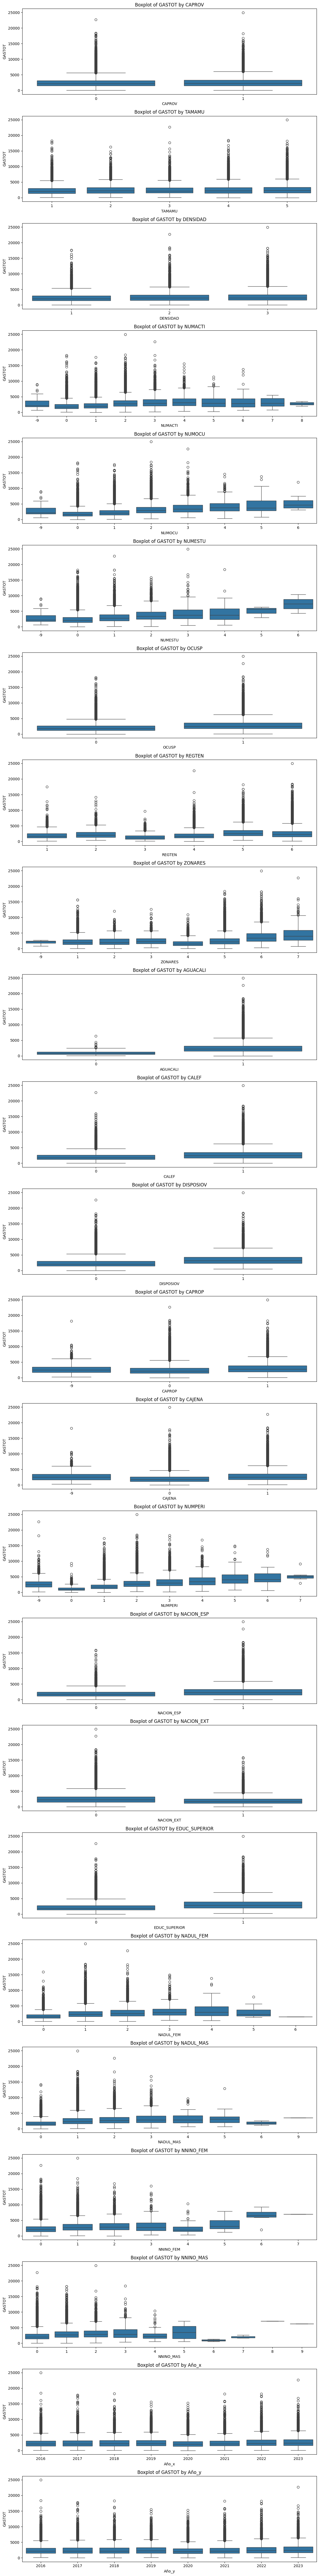

In [15]:
plot_anova_boxplots(df_datalake)

## Analísis de sensibilidad por código

### 🗂 Categorías por código (Super_Categoría)

| Código | Grupo de Gasto |
|--------|----------------|
| 1 | Alimentos y bebidas no alcohólicas |
| 2 | Bebidas alcohólicas, tabaco y narcóticos |
| 3 | Artículos de vestir y calzado |
| 4 | Vivienda, agua, electricidad, gas y otros combustibles |
| 5 | Mobiliario, equipamiento del hogar y gastos de conservación |
| 6 | Salud |
| 7 | Transportes |
| 8 | Comunicaciones |
| 9 | Ocio, espectáculos y cultura |
| 10 | Enseñanza |
| 11 | Hoteles, cafés y restaurantes |
| 12 | Otros bienes y servicios |



In [16]:
from scipy.stats import pearsonr, f_oneway
import glob

In [17]:
def load_homes_external(datalake_path):
    """
    Carga y une los archivos homes.tsv y external_indicators.tsv de todos los años en un único DataFrame.
    La unión se realiza por 'Año' y 'CCAA'.
    """
    all_homes = glob.glob(os.path.join(datalake_path, "*", "homes.tsv"))
    all_external = glob.glob(os.path.join(datalake_path, "*", "external_indicators.tsv"))

    df_list = []

    for home_file, external_file in zip(all_homes, all_external):
        year = os.path.basename(os.path.dirname(home_file))  # Extraer el año de la ruta

        df_homes = pd.read_csv(home_file, sep="\t")
        df_external = pd.read_csv(external_file, sep="\t")

        df_homes["Año"] = int(year)
        df_external["Año"] = int(year)

        # Unir por Año y CCAA
        df_merged = pd.merge(df_homes, df_external, on=["Año", "CCAA"], how="inner")
        df_list.append(df_merged)

    if not df_list:
        raise ValueError("No se encontraron archivos homes.tsv o external_indicators.tsv en la ruta del datalake.")

    # Concatenar todos los DataFrames
    df_homes_external = pd.concat(df_list, ignore_index=True)
    return df_homes_external

In [18]:
def merge_with_datamart(df_homes_external, datamart_path):
    """
    Une el DataFrame combinado de homes y external_indicators con el datamart de supercategorías.
    La unión se realiza por 'Año' y 'NUMERO'.
    """
    df_datamart = pd.read_csv(datamart_path, sep="\t")

    # Unir por Año y NUMERO
    df_final = pd.merge(df_datamart, df_homes_external, on=["Año", "NUMERO"], how="inner")
    return df_final


In [19]:
# Ruta del Datalake y archivo Datamart
datalake_path = "../../Datalake/"
datamart_path = "../../datamarts/datamart_supercategories.tsv"

# Cargar datos de homes y external_indicators
df_homes_external = load_homes_external(datalake_path)

# Unir con el datamart
df_final = merge_with_datamart(df_homes_external, datamart_path)

# Eliminar las columnas que no se utilizarán en el análisis
# df_final.drop(columns=["NUMERO", "Año", "CCAA", "FACTOR", "Comunidad_Autonoma"], inplace=True)

In [20]:
df_final.head()

,Año,NUMERO,SUPER_CATEGORIA,GASTO_MENSUAL,CCAA,CAPROV,TAMAMU,DENSIDAD,NUMACTI,NUMOCU,NUMESTU,EDADSP,OCUSP,REGTEN,ZONARES,SUPERF,AGUACALI,CALEF,DISPOSIOV,CAPROP,CAJENA,IMPEXAC,GASTOT,FACTOR,NUMPERI,NACION_ESP,NACION_EXT,EDUC_SUPERIOR,NADUL_FEM,NADUL_MAS,NNINO_FEM,NNINO_MAS,Comunidad_Autonoma,Tmax_max,Tmin_min,Tasa_Paro,Inflacion,Tipo_Interes
0,2016,1,1,88.712448,7,0,1,1,2,2,0,66,1,5,3,96,1,1,0,1,0,1225,14239915.96,742.998897,2,1,0,0,1,1,0,0,Castilla-La Mancha,42.9,-8.0,18.3,1.6,0.0
1,2016,1,2,2.970634,7,0,1,1,2,2,0,66,1,5,3,96,1,1,0,1,0,1225,14239915.96,742.998897,2,1,0,0,1,1,0,0,Castilla-La Mancha,42.9,-8.0,18.3,1.6,0.0
2,2016,1,3,18.523350,7,0,1,1,2,2,0,66,1,5,3,96,1,1,0,1,0,1225,14239915.96,742.998897,2,1,0,0,1,1,0,0,Castilla-La Mancha,42.9,-8.0,18.3,1.6,0.0
3,2016,1,4,455.425600,7,0,1,1,2,2,0,66,1,5,3,96,1,1,0,1,0,1225,14239915.96,742.998897,2,1,0,0,1,1,0,0,Castilla-La Mancha,42.9,-8.0,18.3,1.6,0.0
4,2016,1,5,4.436967,7,0,1,1,2,2,0,66,1,5,3,96,1,1,0,1,0,1225,14239915.96,742.998897,2,1,0,0,1,1,0,0,Castilla-La Mancha,42.9,-8.0,18.3,1.6,0.0


### Graficamos los coeficientes por categoría (normalizados)

In [21]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def run_regression_by_category_normalized(df, target_variable="GASTO_MENSUAL"):
    """
    Ejecuta una regresión lineal múltiple con variables normalizadas para cada supercategoría
    y devuelve los coeficientes y p-valores.
    """
    results = {}
    coefficients = []

    # Variables explicativas (excluimos algunas específicas)
    independent_vars = df.select_dtypes(include=["number"]).columns.tolist()
    independent_vars = [var for var in independent_vars if var not in ["Año", "NUMERO", "GASTO_MENSUAL", "CCAA", "SUPER_CATEGORIA", "FACTOR", "NACION_EXT", "GASTOT"]]

    for category in df["SUPER_CATEGORIA"].unique():
        df_category = df[df["SUPER_CATEGORIA"] == category].dropna()

        if len(df_category) < len(independent_vars):
            continue

        X = df_category[independent_vars]
        y = df_category[target_variable]

        # Normalizar variables independientes
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        X_scaled = sm.add_constant(X_scaled)  # Agregar intercepto
        model = sm.OLS(y, X_scaled).fit()

        results[category] = model

        # Guardar coeficientes y p-valores
        coef_df = pd.DataFrame({
            "Variable": model.params.index,
            "Coeficiente": model.params.values,
            "P-Valor": model.pvalues.values,
            "Super_Categoria": category
        })

        coef_df = coef_df[coef_df["P-Valor"] < 0.05]
        coefficients.append(coef_df)

    coefficients_df = pd.concat(coefficients, ignore_index=True)
    return results, coefficients_df



In [22]:
def plot_coefficients_per_category(coefficients_df):
    """
    Genera un gráfico de barras por cada supercategoría mostrando el impacto de las variables en el gasto.
    """

    categoria_nombre = {
        1: "Alimentos",
        2: "Alcohol y tabaco",
        3: "Vestimenta",
        4: "Vivienda",
        5: "Hogar",
        6: "Salud",
        7: "Transporte",
        8: "Comunicaciones",
        9: "Ocio y cultura",
        10: "Educación",
        11: "Restaurantes",
        12: "Otros"
    }

    coefficients_df["Nombre_Categoria"] = coefficients_df["Super_Categoria"].map(categoria_nombre)

    for category in coefficients_df["Super_Categoria"].unique():
        df_cat = coefficients_df[coefficients_df["Super_Categoria"] == category]

        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")
        plt.axhline(0, color="black", linestyle="--")
        plt.xticks(rotation=90)

        nombre_categoria = categoria_nombre.get(category, f"Categoría {category}")
        plt.title(f"Impacto (normalizado) de variables en {category} - {nombre_categoria}")
        plt.xlabel("Variables Explicativas")
        plt.ylabel("Coeficiente de la Regresión")
        plt.tight_layout()
        plt.show()


C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


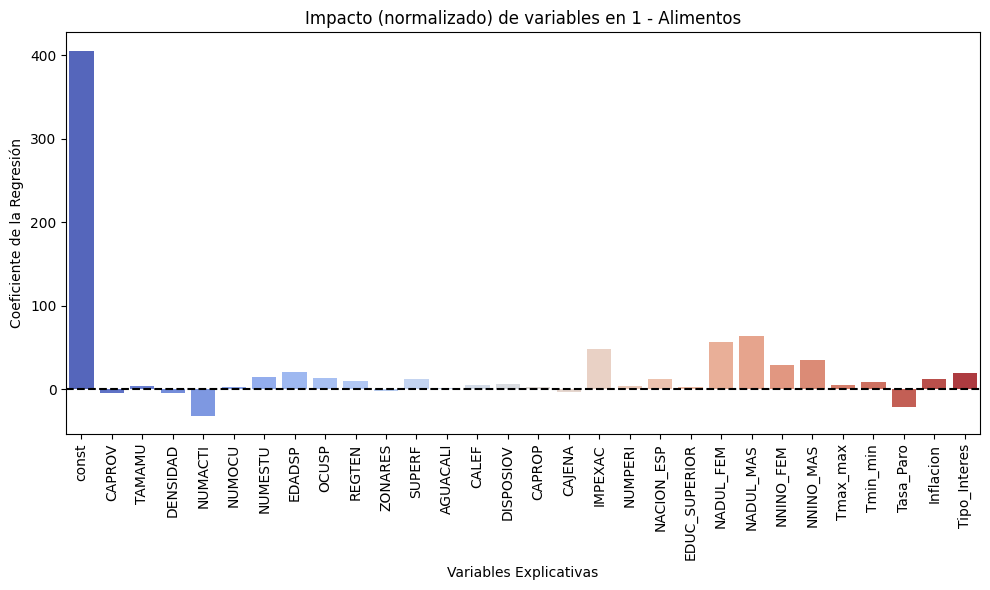

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


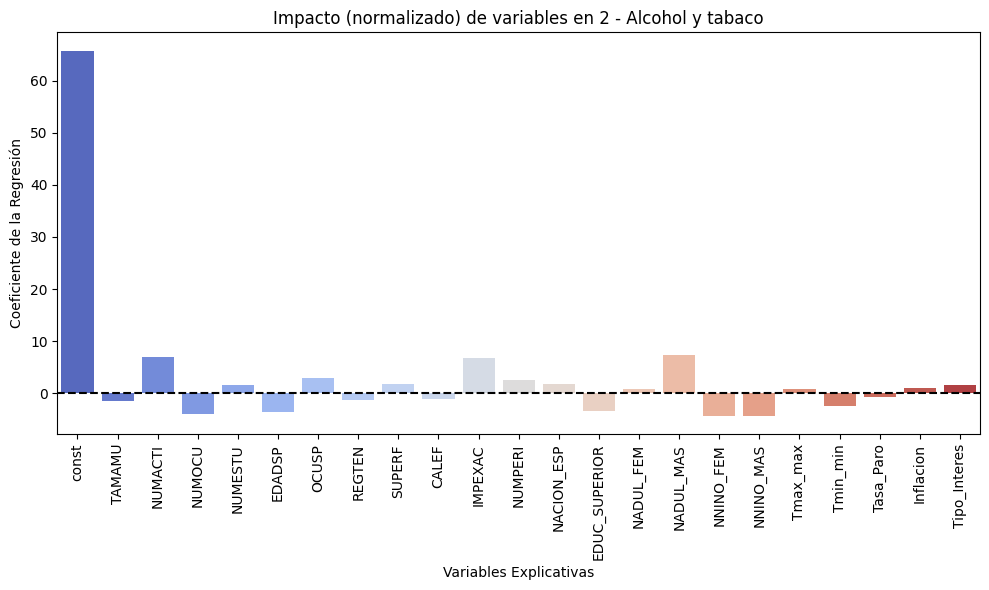

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


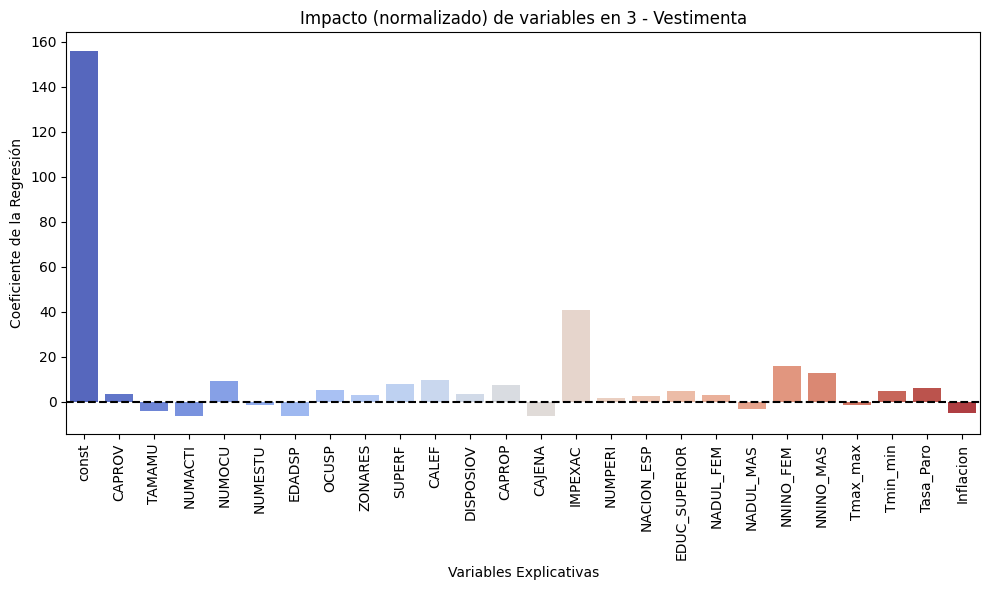

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


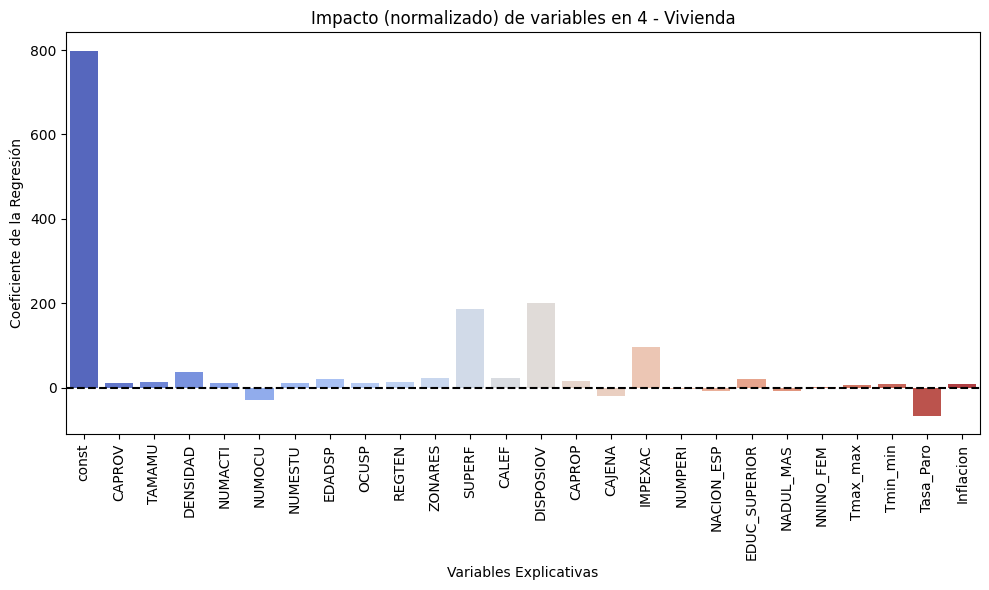

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


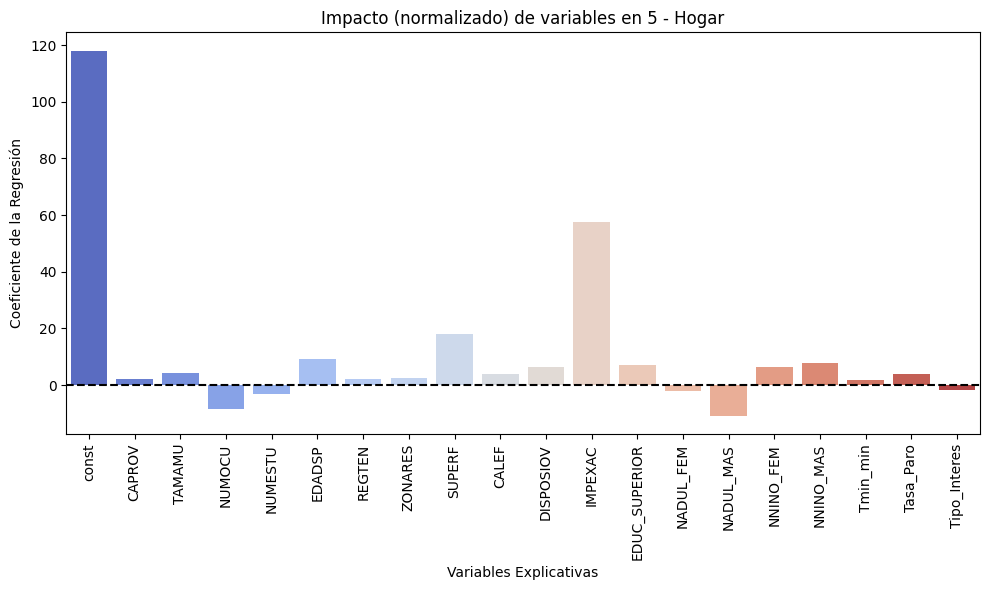

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


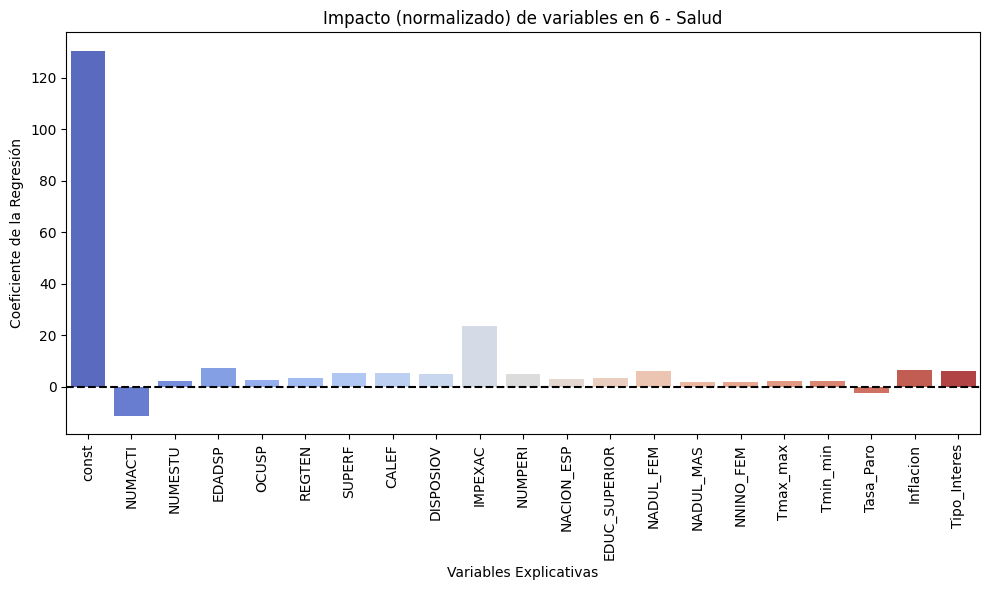

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


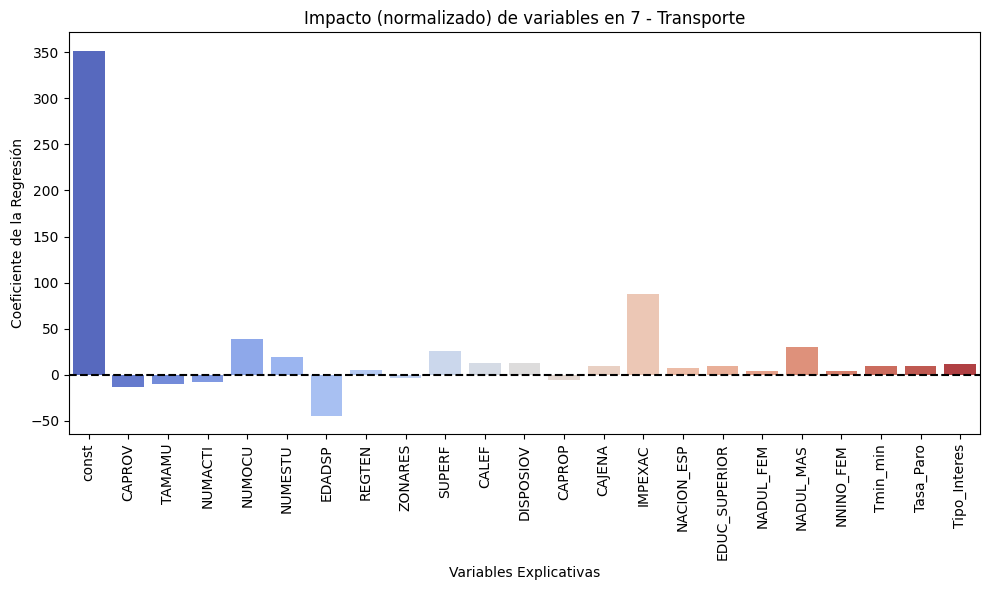

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


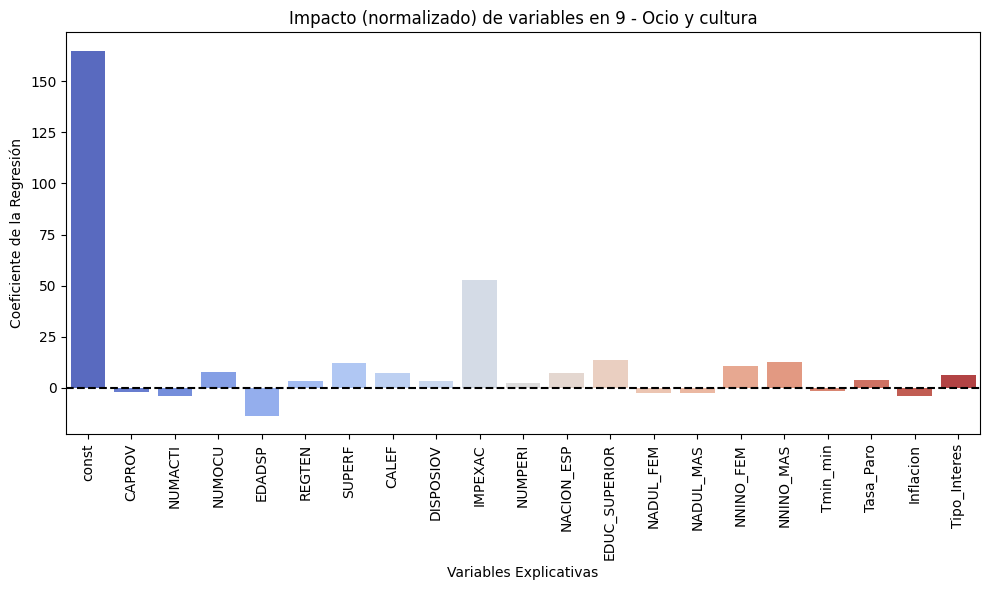

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


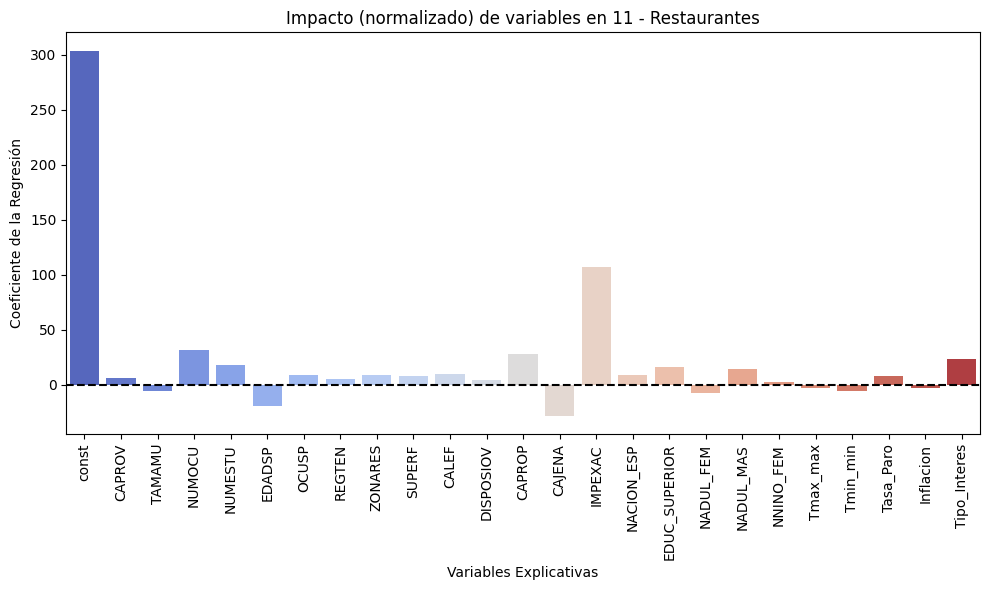

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


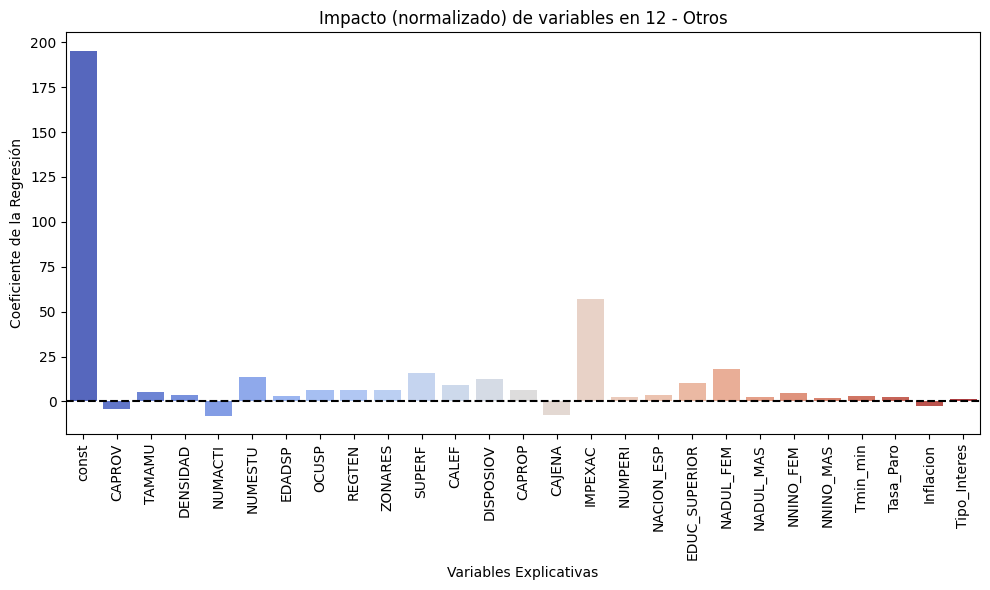

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


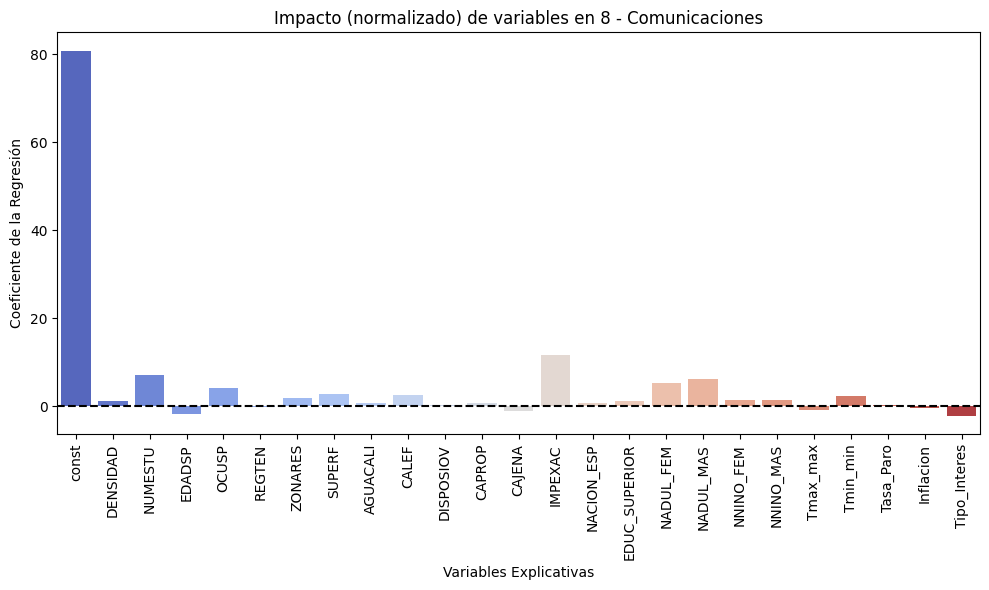

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\2189735207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


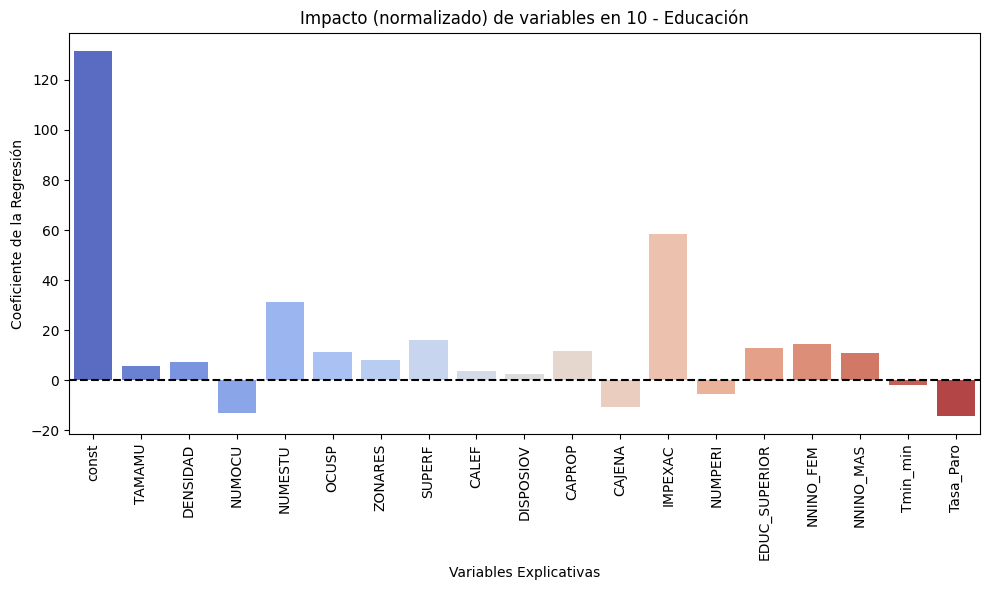

In [23]:
# Ejecutar regresión con variables normalizadas
regression_results, coefficients_df = run_regression_by_category_normalized(df_final)

# Graficar los coeficientes más importantes por supercategoría
plot_coefficients_per_category(coefficients_df)

## 📐 Interpretación de un Modelo de Regresión Lineal Múltiple Normalizado

### 🔄 ¿Qué significa "normalizado"?

Cuando se normaliza un modelo, las variables se transforman para que tengan:

- **Media = 0**
- **Desviación estándar = 1**

Esta normalización se aplica a las variables explicativas (X), y opcionalmente también a la variable dependiente (y).

---

### 🎯 ¿Cómo se interpretan los coeficientes?

En un modelo normalizado, **los coeficientes se interpretan en términos de desviaciones estándar**:

> Un coeficiente indica cuántas desviaciones estándar cambia la variable dependiente por cada desviación estándar de cambio en la variable independiente, manteniendo las demás constantes.

---

### 💡 Ejemplo de interpretación

- Si el coeficiente de `IMPEXAC` es **+1.2**:
  - Entonces, **un aumento de 1 desviación estándar en los ingresos (`IMPEXAC`)** se asocia con un aumento de **1.2 desviaciones estándar en el gasto mensual**.

- Si el coeficiente de `NUMESTU` es **-0.5**:
  - Entonces, **un aumento de 1 desviación estándar en el número de estudiantes** se asocia con una **disminución de 0.5 desviaciones estándar en el gasto mensual**.

---

### ✅ Ventajas de la normalización

- Permite **comparar directamente el peso relativo de cada variable** en el modelo.
- Evita que variables con escalas más grandes dominen el modelo por su magnitud.
- Es útil en modelos con muchas variables heterogéneas (e.g. edad, ingresos, tamaño del hogar, etc.).

---

### ⚠️ Consideraciones

- Los coeficientes ya no están en unidades interpretables (euros, años, personas...).
- Solo tiene sentido si se desea analizar **la importancia relativa** de las variables, no el efecto real en magnitudes absolutas.


### Obtenemos los coeficientes reales y vemos en que categorís impacta más cada variable y cuánto

In [24]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

def run_regression_by_category_normalized(df, target_variable="GASTO_MENSUAL"):
    """
    Ejecuta una regresión lineal múltiple con variables normalizadas para cada supercategoría,
    eliminando automáticamente la multicolinealidad y las variables no significativas.
    Devuelve los modelos por categoría y los coeficientes significativos.
    """
    
    def eliminar_multicolinealidad(X, threshold=5.0):
        """Elimina variables con VIF superior al umbral."""
        while True:
            vif = pd.Series(
                [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns
            )
            max_vif = vif.max()
            if max_vif > threshold:
                var_eliminar = vif.idxmax()
                X = X.drop(columns=[var_eliminar])
            else:
                break
        return X

    def backward_elimination(X, y, significance_level=0.05):
        """Elimina variables con p-valor superior al umbral."""
        X = sm.add_constant(X, has_constant='add')
        while True:
            model = sm.OLS(y, X).fit()
            p_values = model.pvalues.drop("const", errors="ignore")
            max_p = p_values.max()
            if max_p > significance_level:
                var_eliminar = p_values.idxmax()
                X = X.drop(columns=[var_eliminar])
            else:
                break
        return X

    results = {}
    coefficients = []

    # Variables explicativas (excluyendo las que no interesan)
    independent_vars = df.select_dtypes(include=["number"]).columns.tolist()
    independent_vars = [var for var in independent_vars if var not in ["Año", "NUMERO", "GASTO_MENSUAL", "CCAA", "SUPER_CATEGORIA", "FACTOR", "NACION_EXT", "GASTOT"]]

    for category in df["SUPER_CATEGORIA"].unique():
        df_category = df[df["SUPER_CATEGORIA"] == category].dropna()

        if len(df_category) < len(independent_vars):
            continue

        X = df_category[independent_vars]
        y = df_category[target_variable]

        # Normalización
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        # Eliminar multicolinealidad
        X_vif_clean = eliminar_multicolinealidad(X_scaled)

        # Eliminar variables no significativas
        X_final = backward_elimination(X_vif_clean, y)

        if X_final.shape[1] <= 1:  # Solo constante, saltar
            continue

        model = sm.OLS(y, X_final).fit()
        results[category] = model

        coef_df = pd.DataFrame({
            "Variable": model.params.index,
            "Coeficiente": model.params.values,
            "P-Valor": model.pvalues.values,
            "Super_Categoria": category
        })

        coef_df = coef_df[coef_df["P-Valor"] < 0.05]
        coefficients.append(coef_df)

    if coefficients:
        coefficients_df = pd.concat(coefficients, ignore_index=True)
    else:
        coefficients_df = pd.DataFrame()

    return results, coefficients_df

In [25]:
# Ejecutar la regresión por categoría
results, coefficients_df = run_regression_by_category_normalized(df_final)

In [26]:
# Mostrar coeficientes de IMPEXAC Y ORDENALOS POR COEFICIENTE
coefficients_df[coefficients_df["Variable"] == "IMPEXAC"].sort_values(by="Coeficiente", ascending=False)

,Variable,Coeficiente,P-Valor,Super_Categoria
195,IMPEXAC,113.209888,0.000000e+00,11
152,IMPEXAC,95.268604,0.000000e+00,7
85,IMPEXAC,90.506049,0.000000e+00,4
270,IMPEXAC,58.121625,0.000000e+00,10
220,IMPEXAC,57.017355,0.000000e+00,12
107,IMPEXAC,55.801908,0.000000e+00,5
170,IMPEXAC,54.206879,0.000000e+00,9
14,IMPEXAC,49.223812,0.000000e+00,1
59,IMPEXAC,42.270080,0.000000e+00,3
126,IMPEXAC,23.699713,8.908096e-180,6


In [27]:
def plot_variable_impact_across_categories(coefficients_df):
    """
    Genera un gráfico por cada variable significativa mostrando su coeficiente
    en cada Super_Categoria.
    """
    variables = coefficients_df["Variable"].unique()

    for var in variables:
        # Filtrar el DataFrame para la variable actual
        df_var = coefficients_df[coefficients_df["Variable"] == var].copy()

        # Asegurar tipo string para categorías
        df_var["Super_Categoria"] = df_var["Super_Categoria"].astype(str)

        # Ordenar por coeficiente
        df_var = df_var.sort_values(by="Coeficiente", ascending=False)

        # Gráfico
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")
        plt.axhline(0, color="black", linestyle="--")
        plt.title(f"Impacto de {var} en el gasto mensual por categoría")
        plt.xlabel("Super Categoría")
        plt.ylabel(f"Coeficiente de {var}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


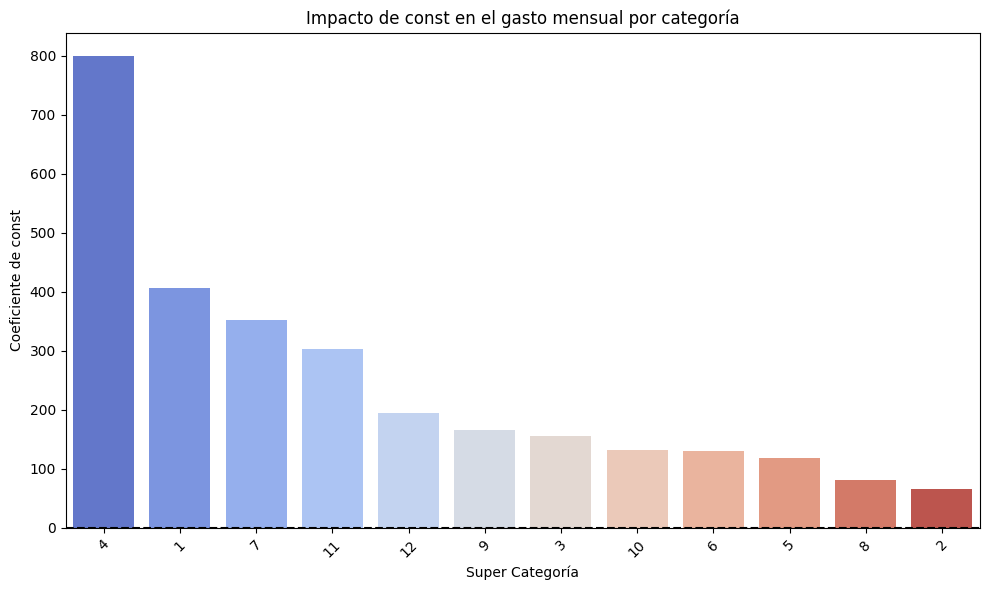

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


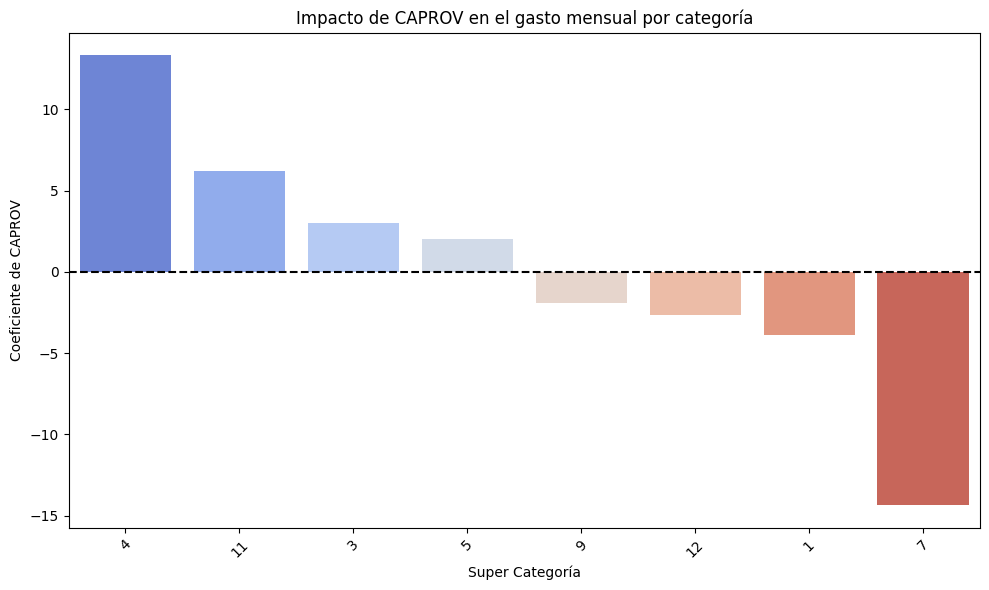

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


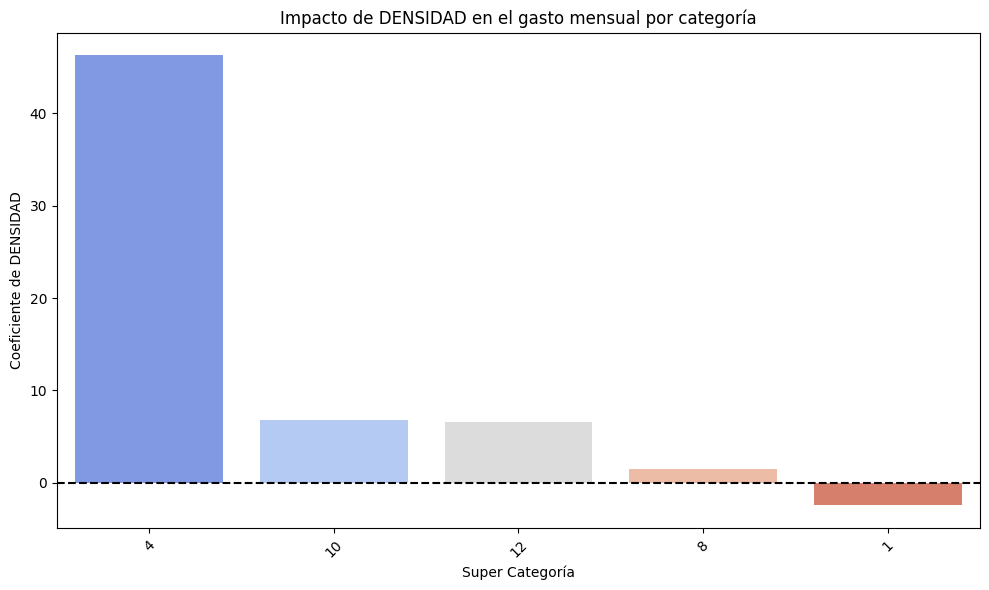

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


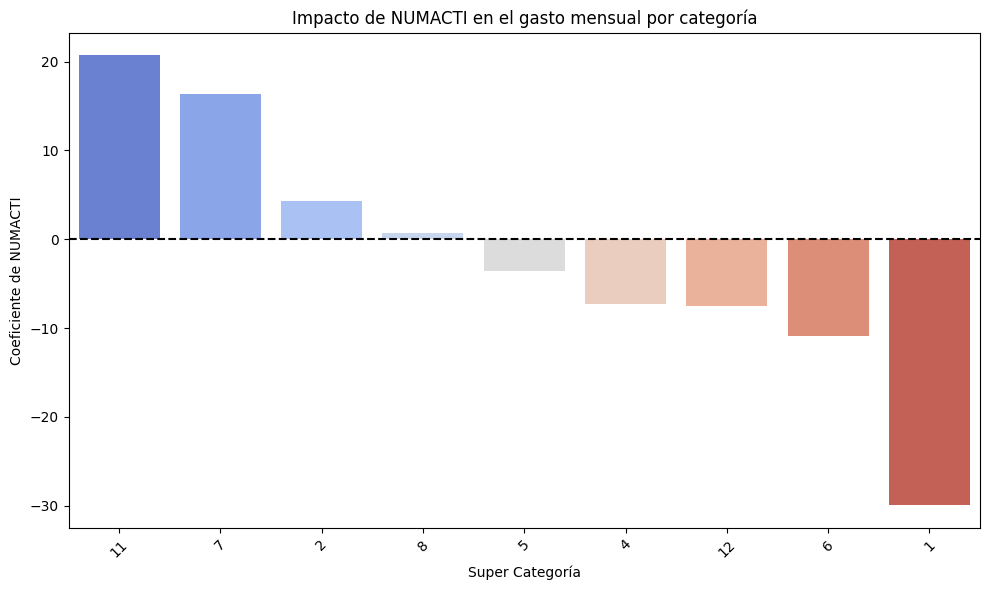

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


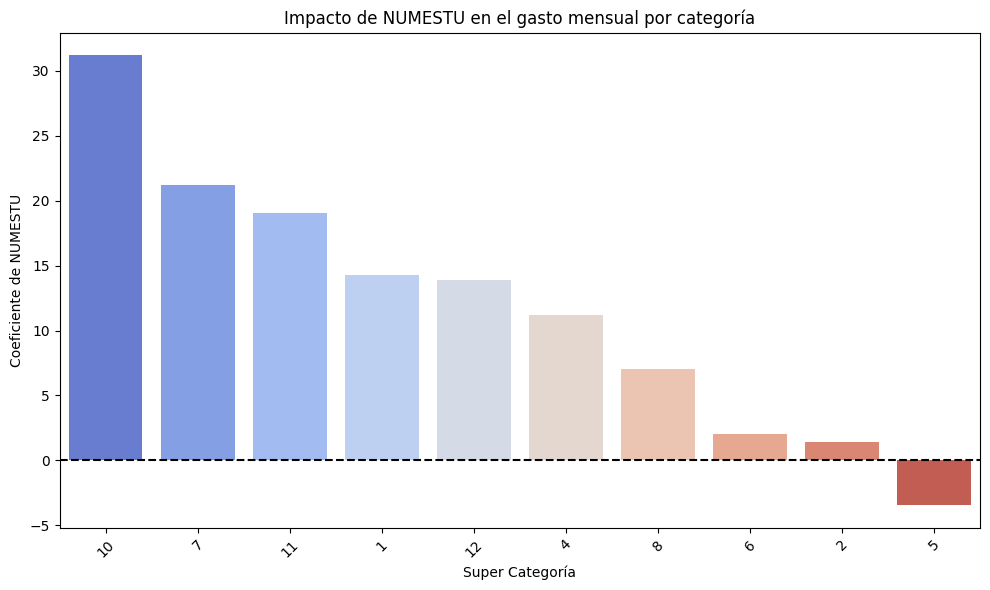

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


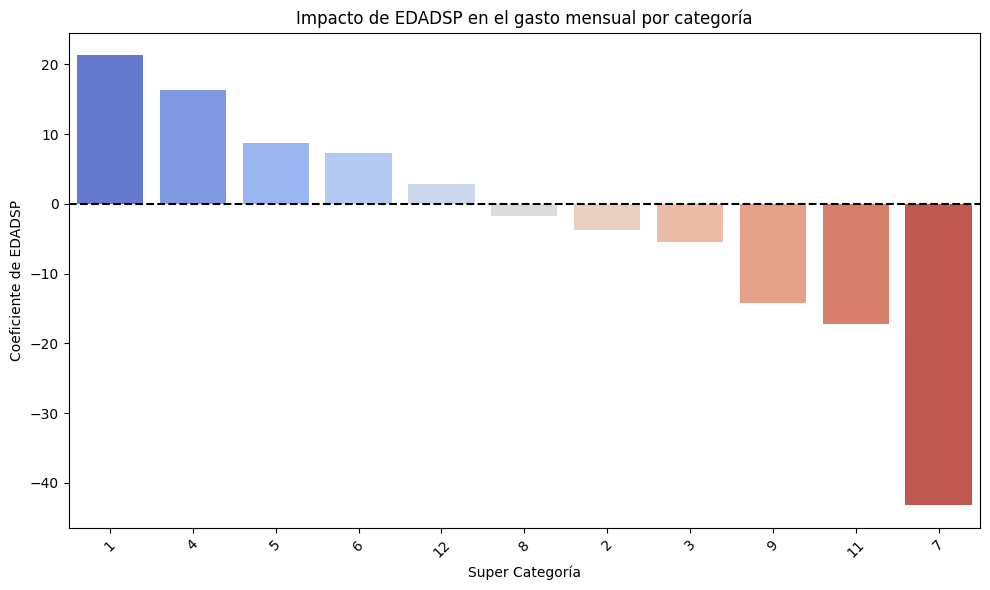

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


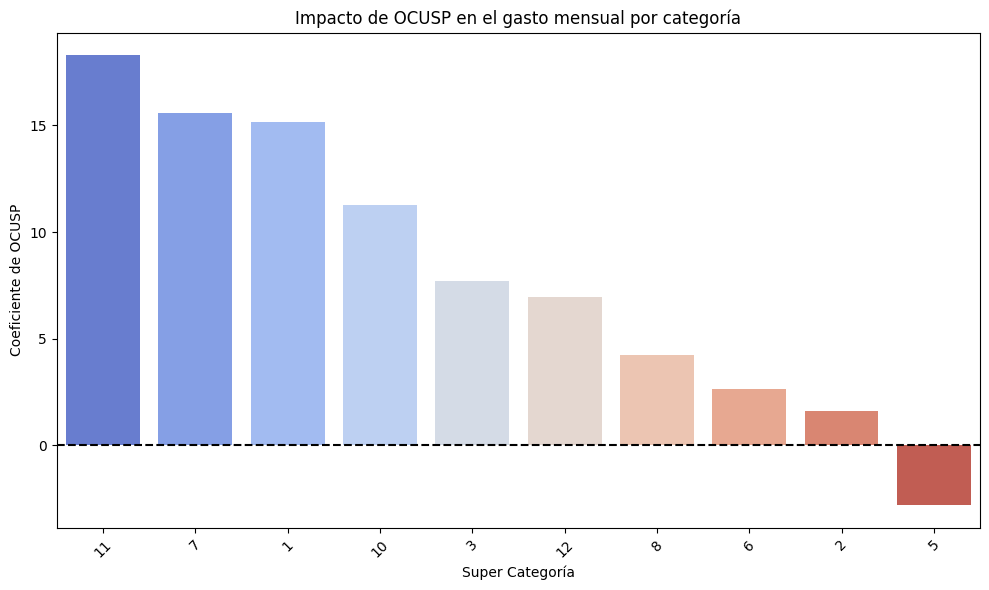

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


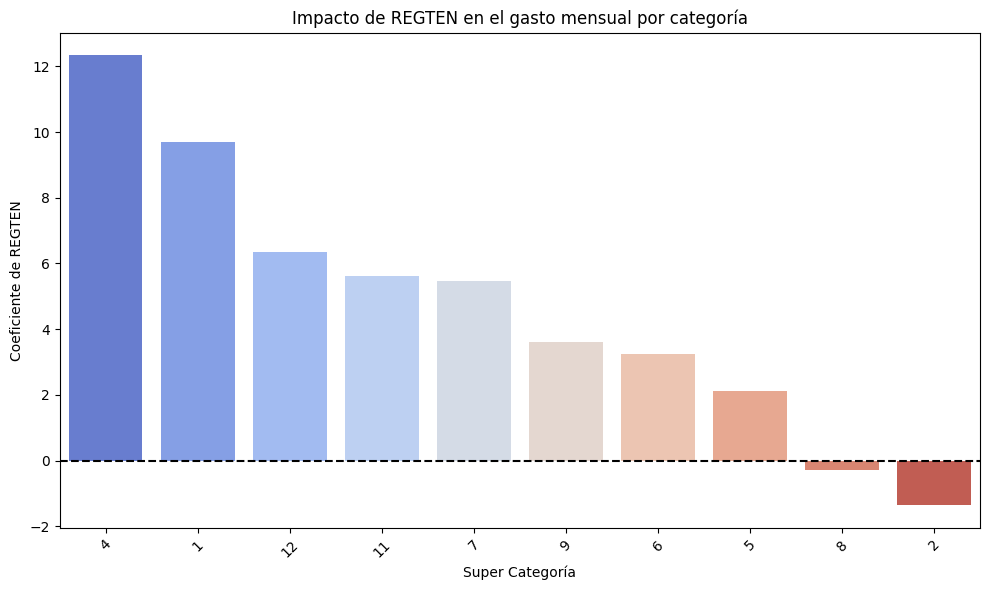

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


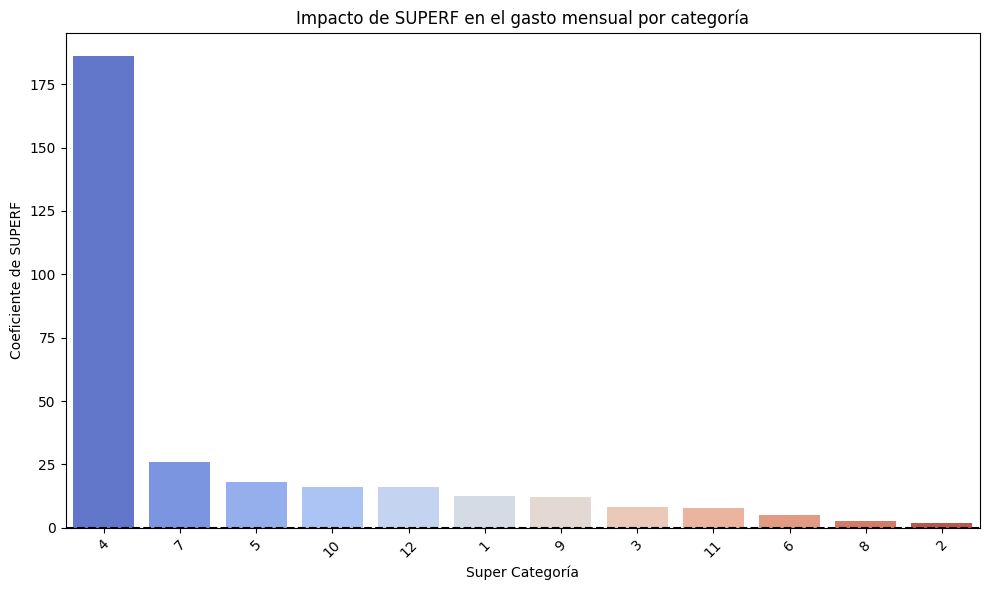

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


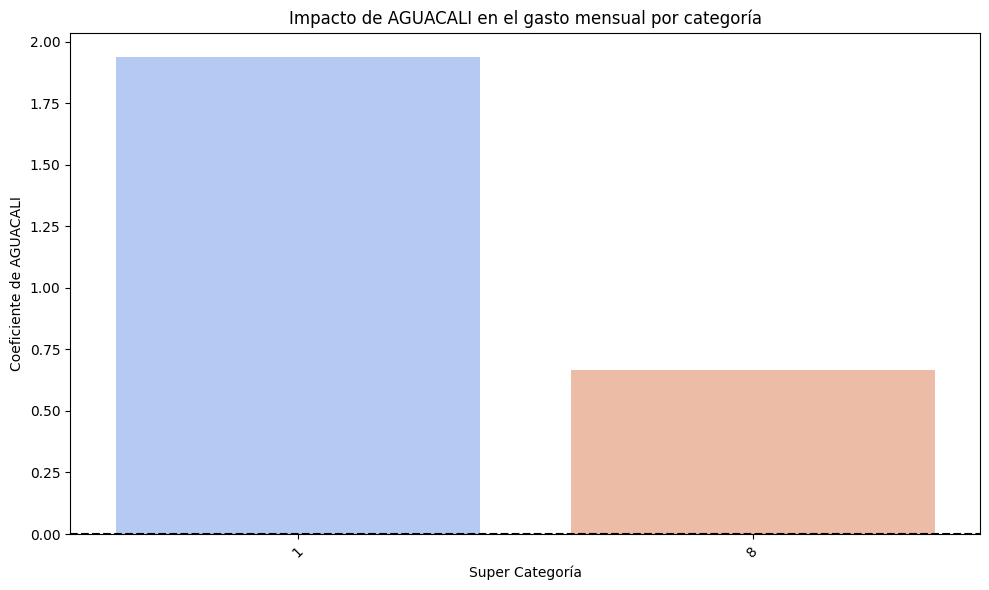

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


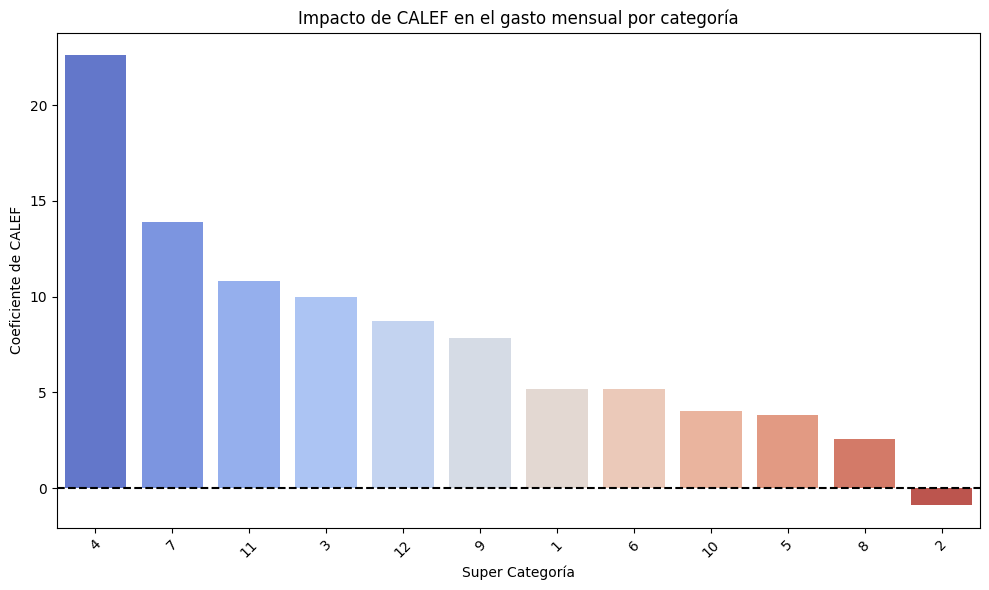

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


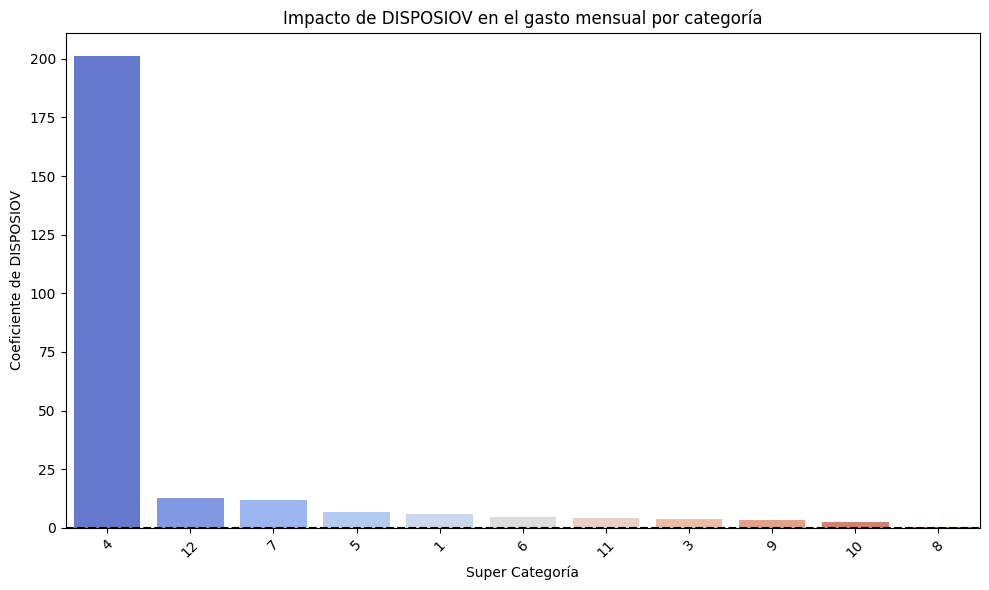

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


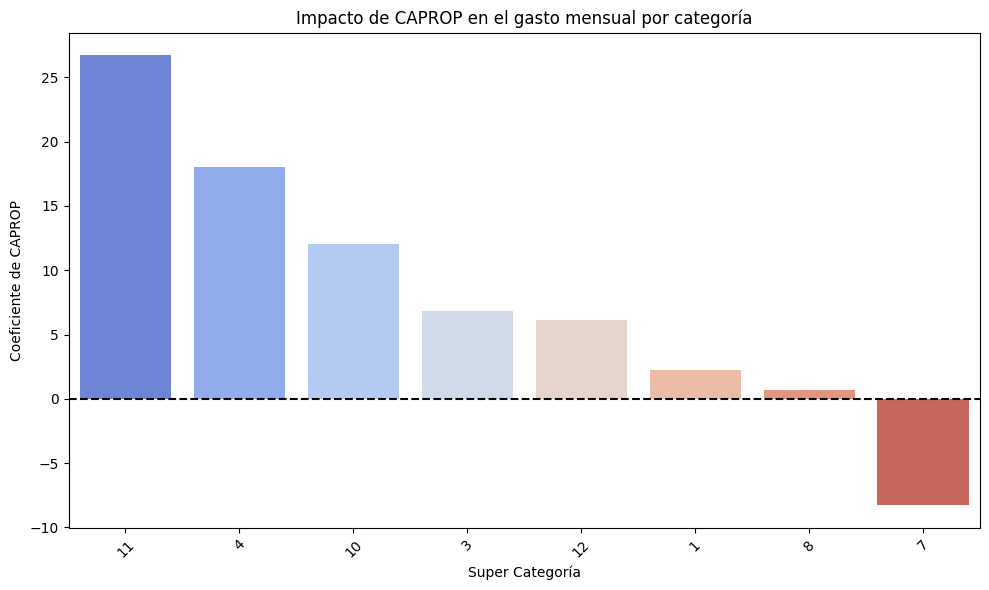

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


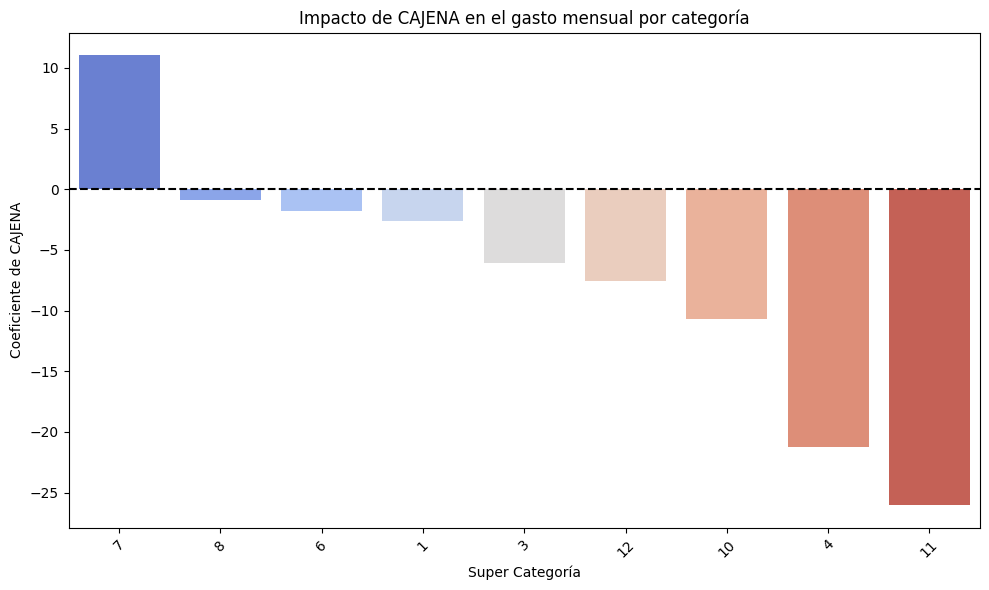

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


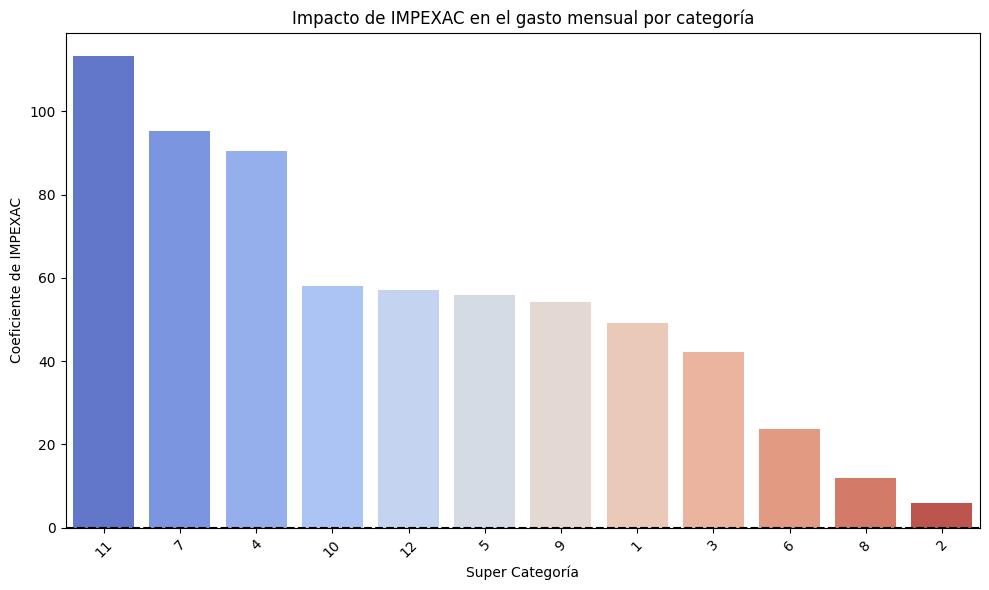

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


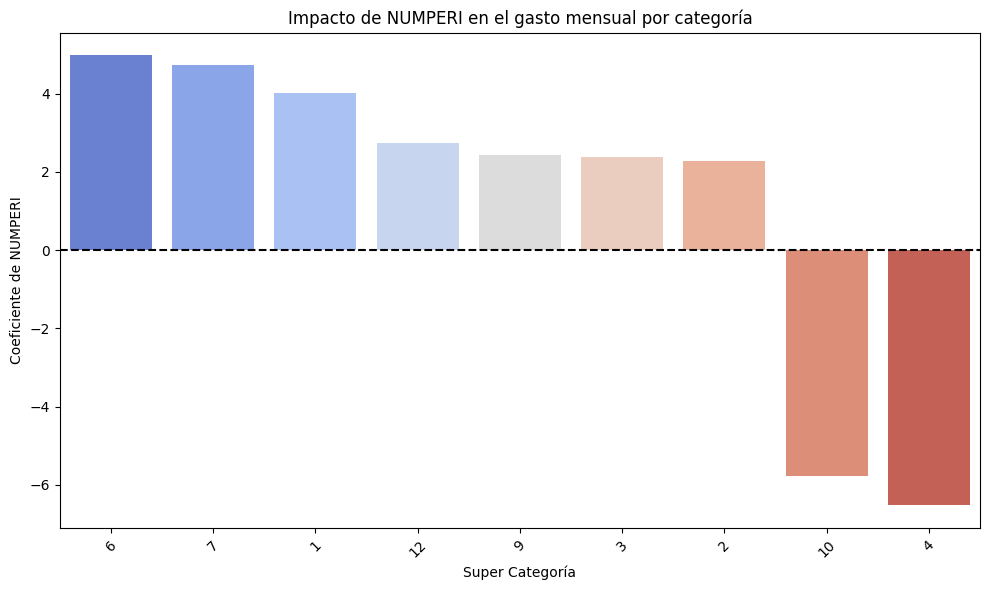

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


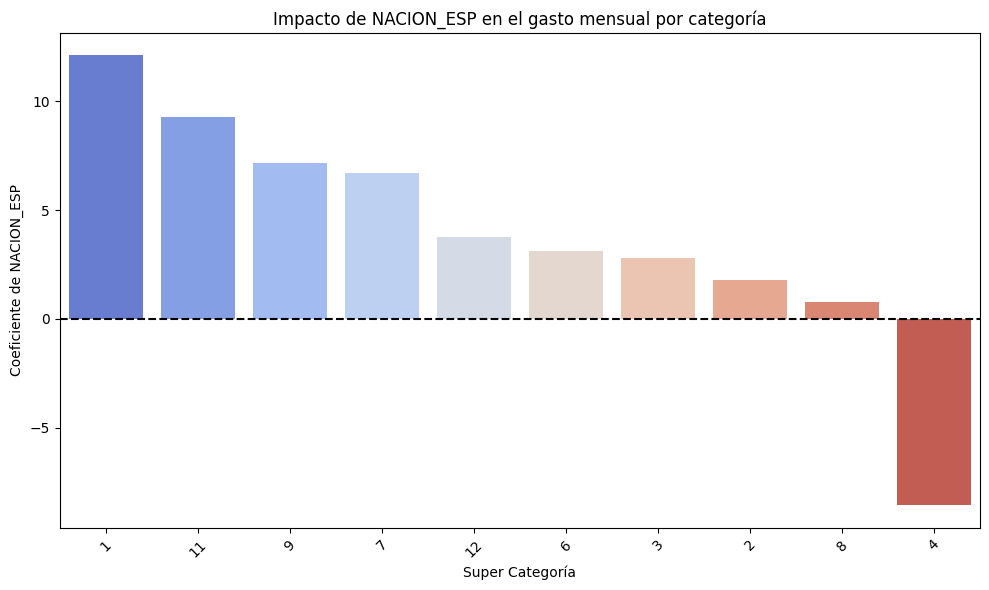

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


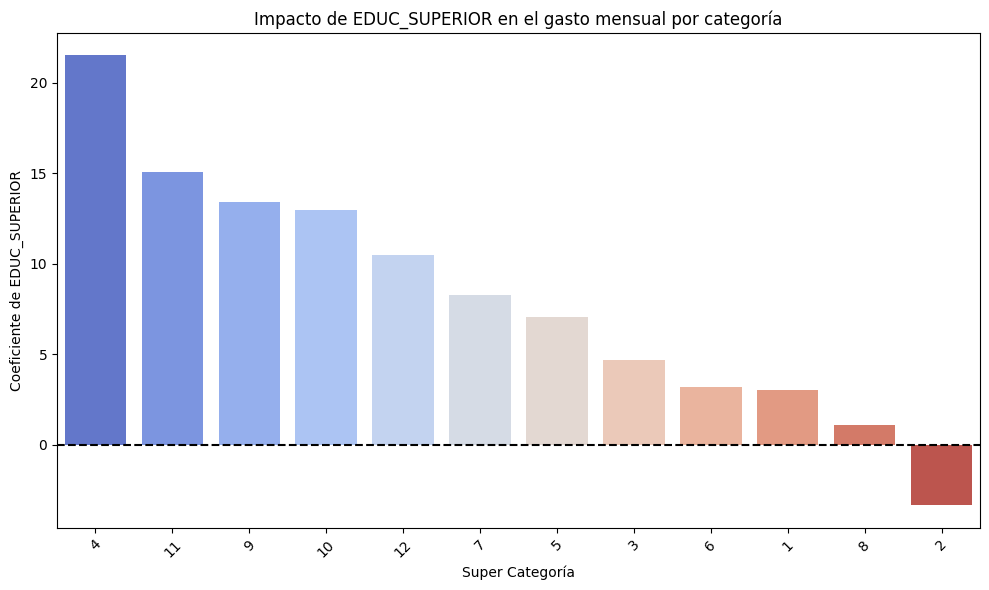

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


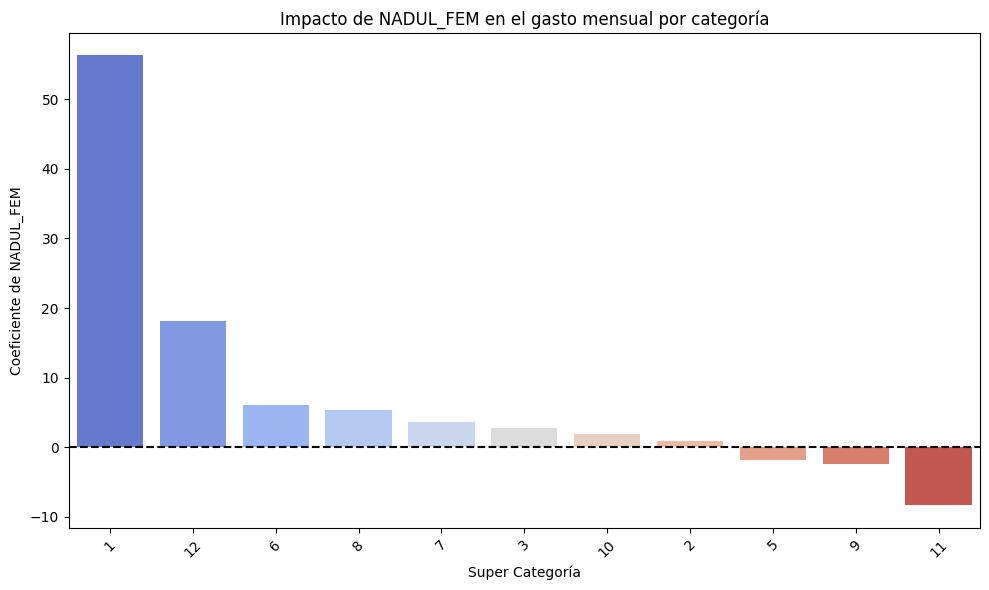

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


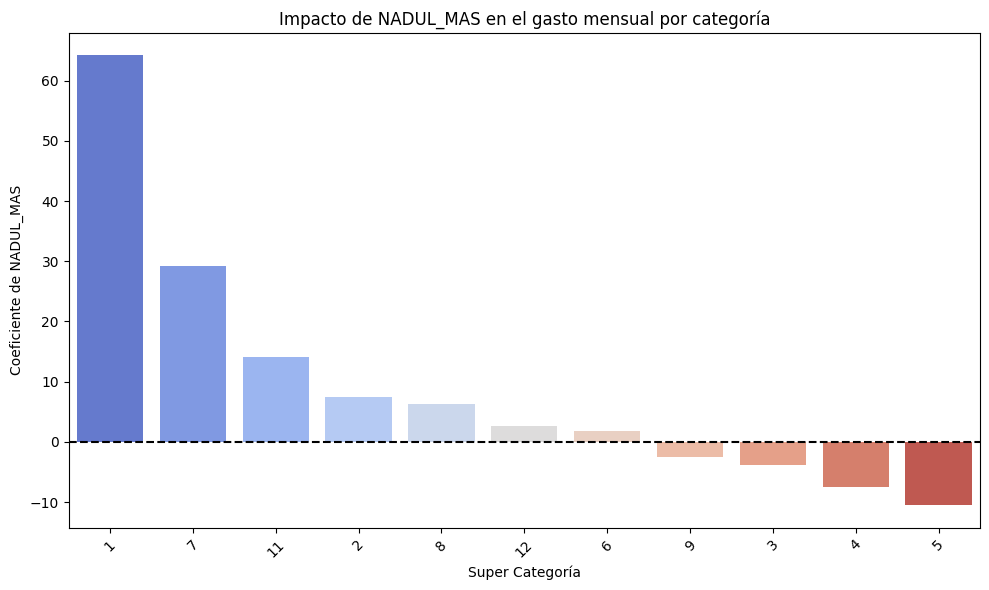

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


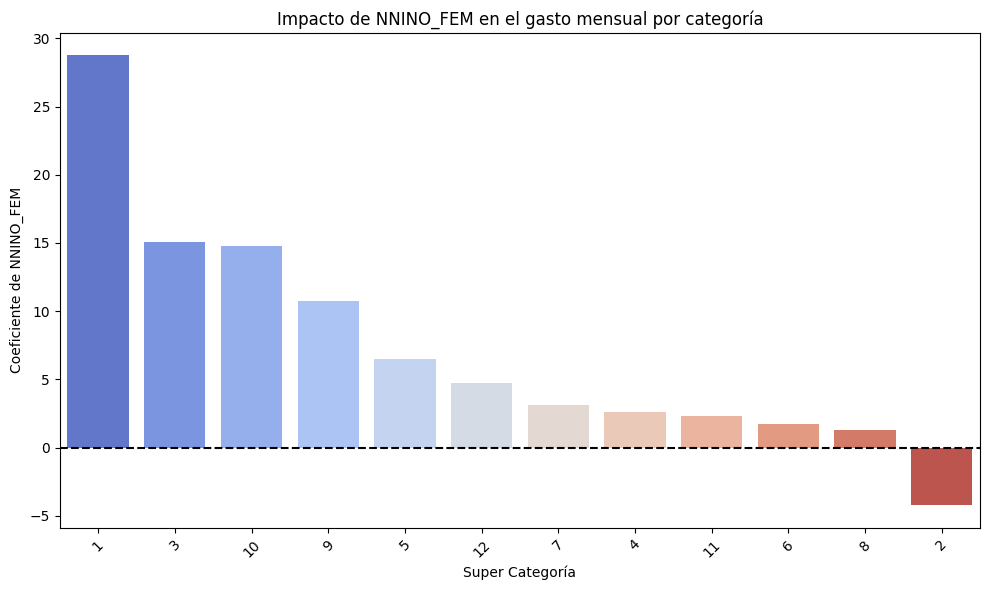

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


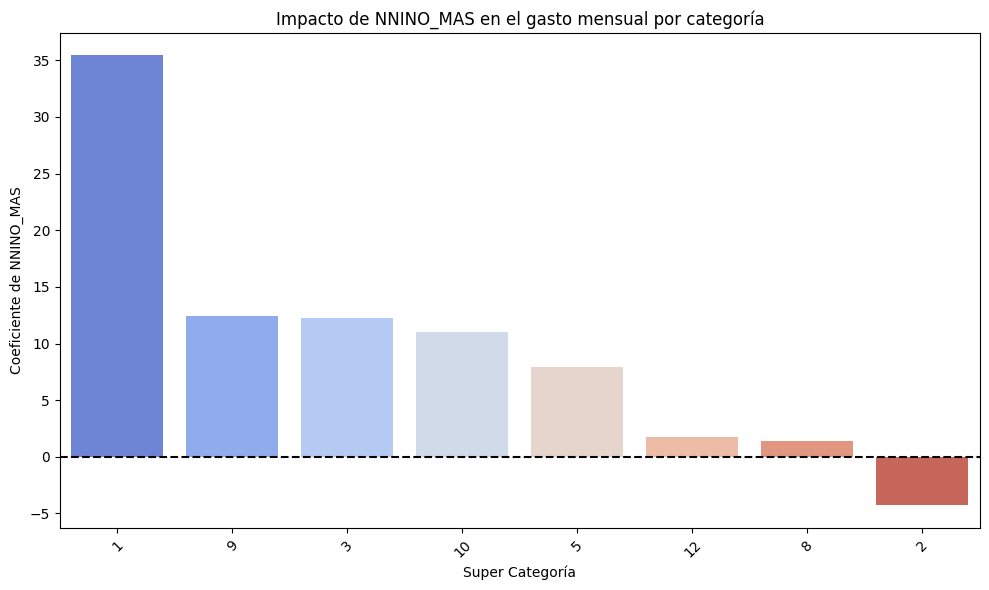

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


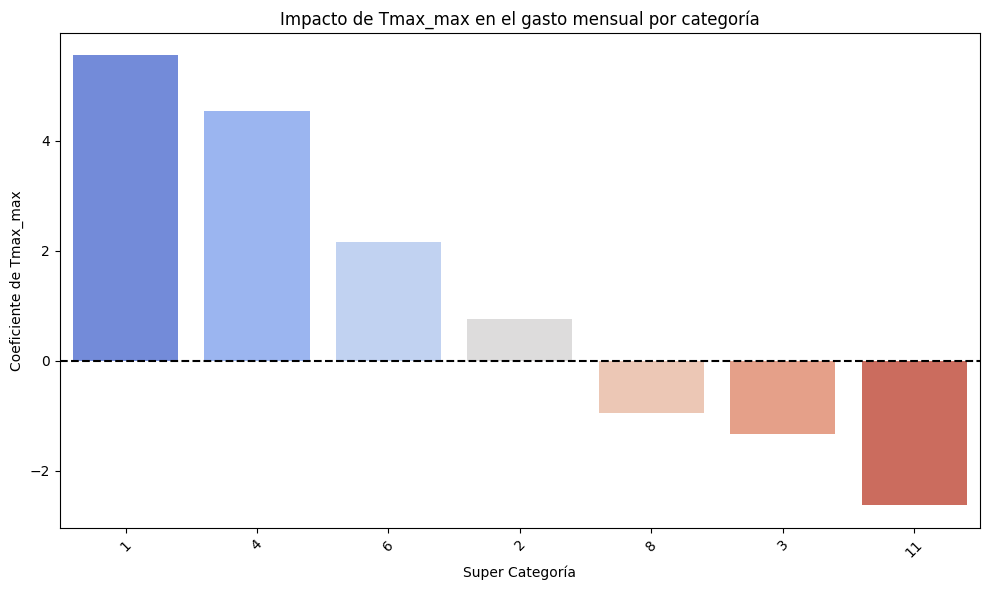

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


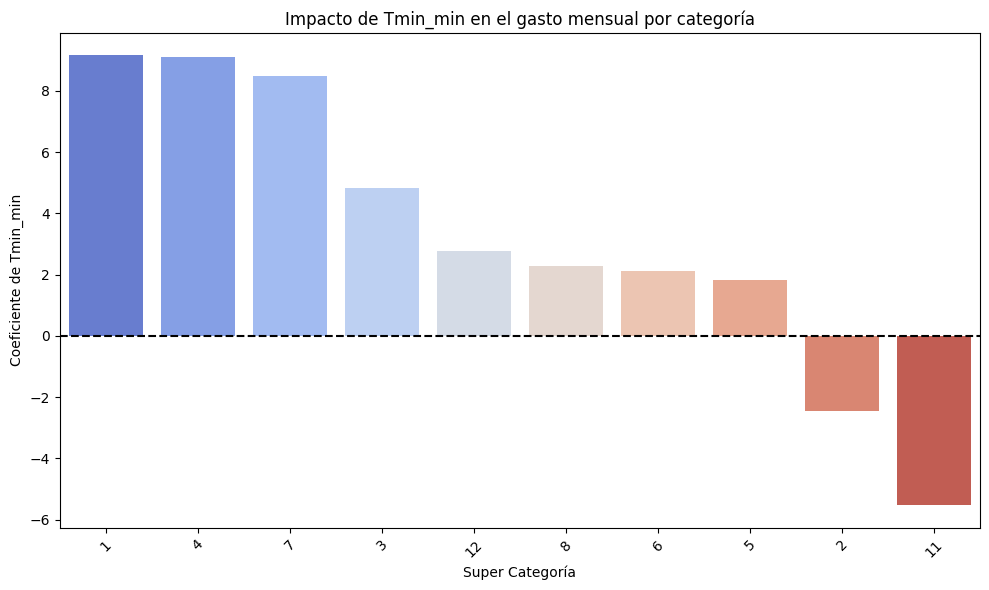

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


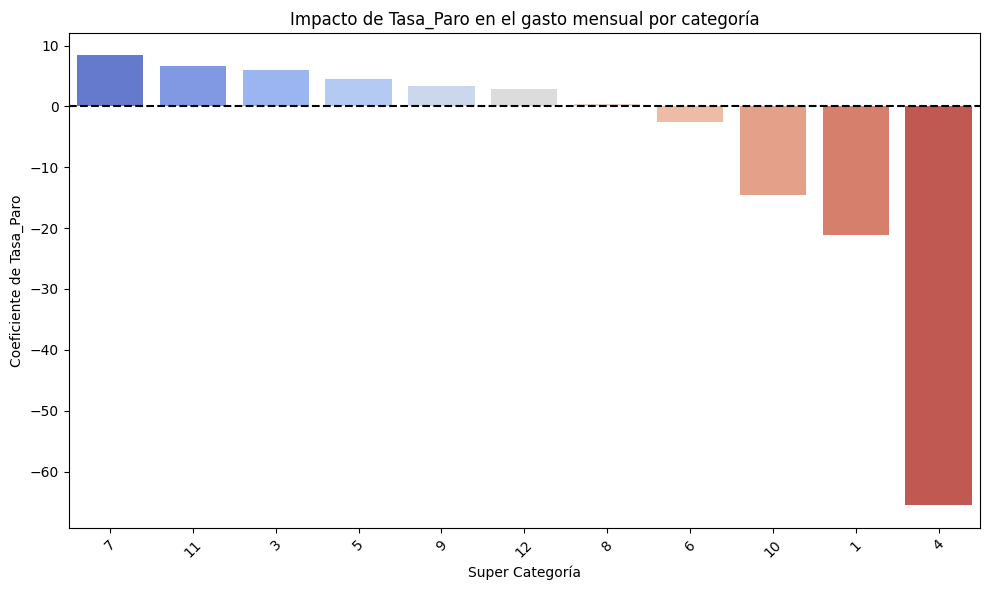

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


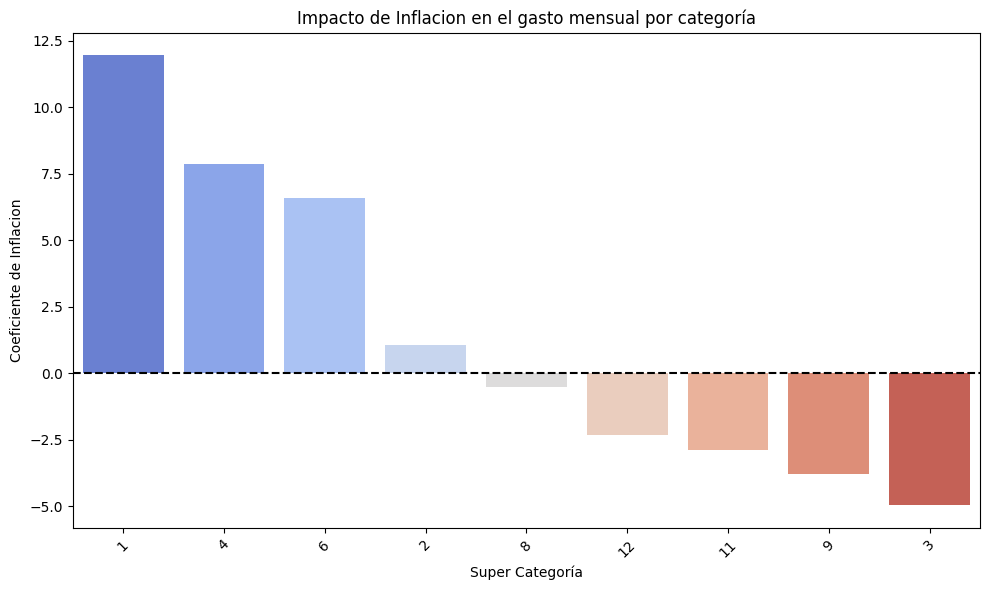

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


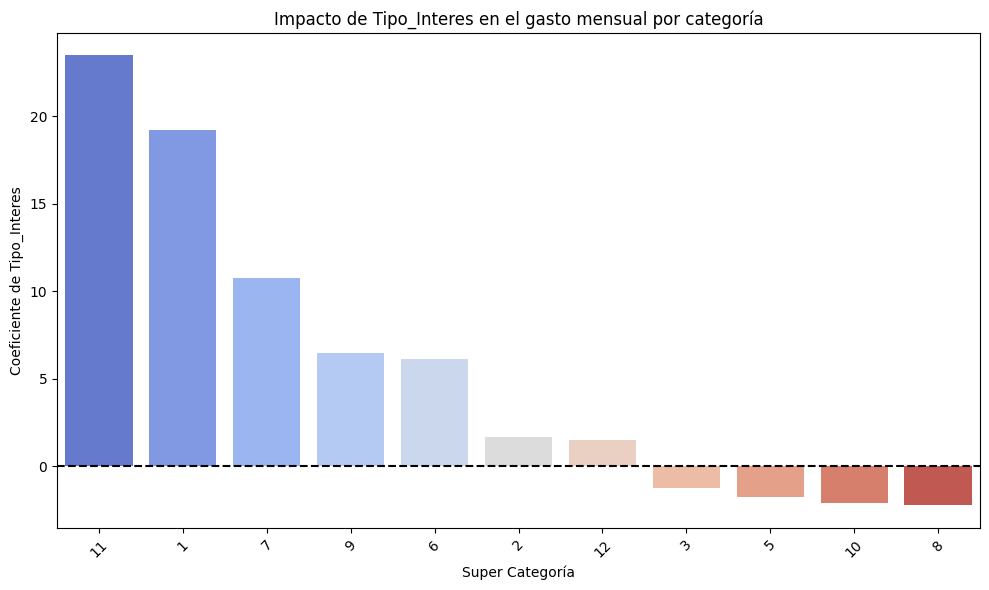

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


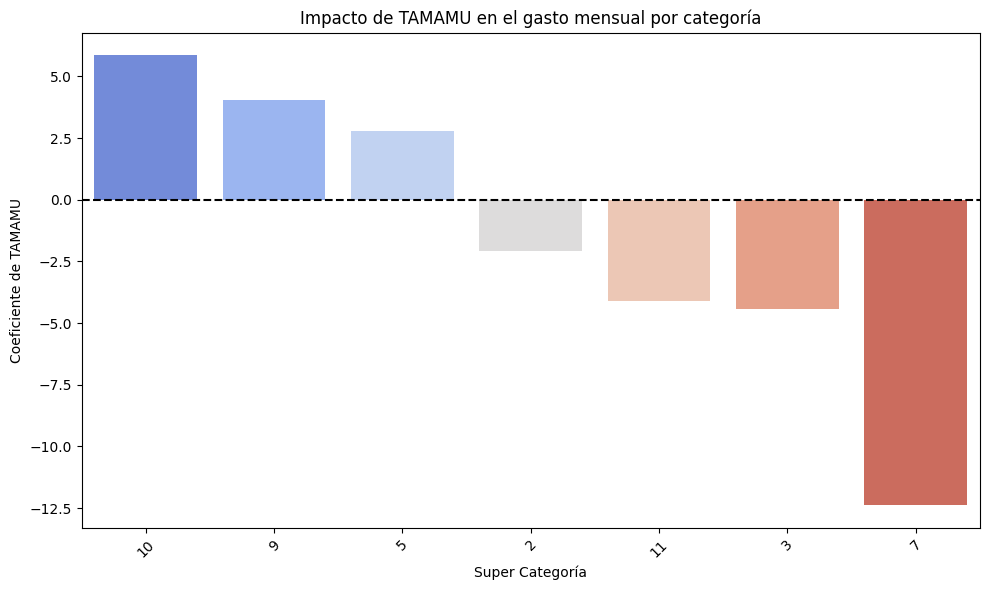

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


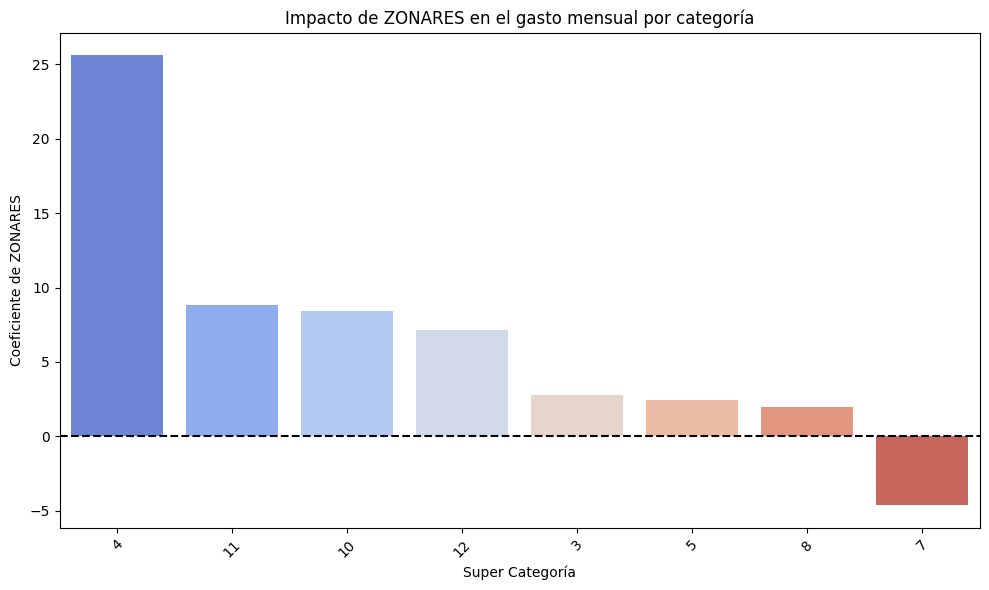

C:\Users\rauul\AppData\Local\Temp\ipykernel_10460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


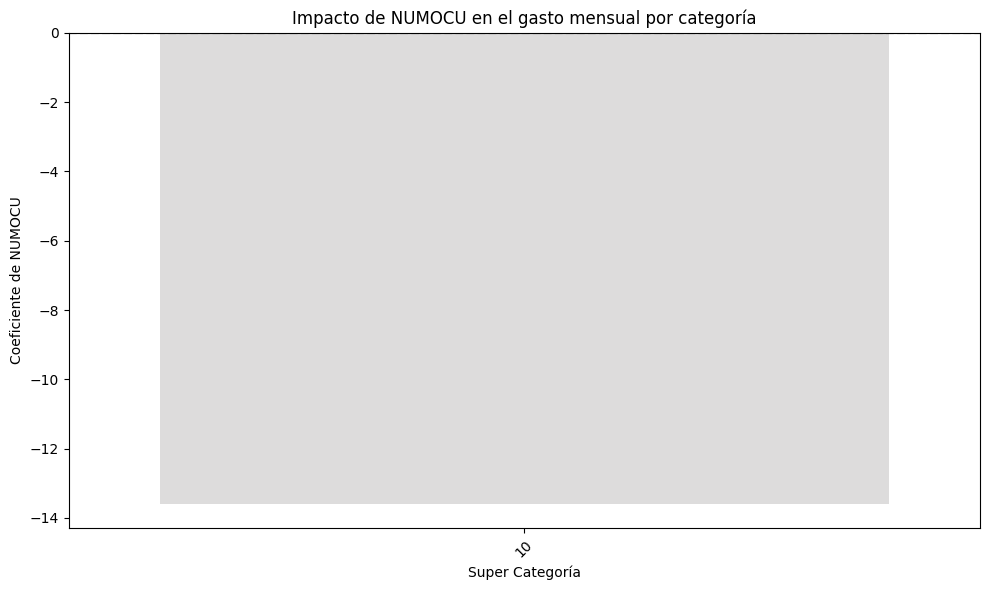

In [28]:
# Graficar el impacto de cada variable significativa
plot_variable_impact_across_categories(coefficients_df)

## 📊 Interpretación de un Modelo de Regresión Lineal Múltiple (sin normalizar)

### 🔍 ¿Qué significa que el modelo no esté normalizado?

En este caso, las variables **se mantienen en sus unidades originales**:

- Ingresos → en euros
- Edad → en años
- Numero de miembros del hogar (`NMIEMB`) → en número de personas
- Etc.

---

### 🎯 Interpretación de los coeficientes

Cada **coeficiente** representa el **cambio esperado en la variable dependiente (por ejemplo, gasto mensual en euros)** al aumentar en **una unidad real** la variable explicativa, manteniendo las demás constantes.

---

### 💡 Ejemplo con `NMIEMB` (Número de miembros del hogar)

El gráfico muestra el efecto de `NMIEMB` (sin normalizar) sobre el gasto mensual en cada categoría:

- En la **categoría 1 (Alimentos y bebidas no alcohólicas)**, el coeficiente es **+12** →  
  → *Cada miembro adicional en el hogar incrementa el gasto en alimentación en aproximadamente 12 euros.*

- En la **categoría 4 (Vivienda, agua, electricidad, gas)**, el coeficiente es **-7** →  
  → *Cada miembro adicional se asocia con una reducción del gasto en vivienda de unos 7 euros, posiblemente por reparto de costes fijos.*

- En la **categoría 10 (Enseñanza)**, el coeficiente es **+10** →  
  → *Hogares con más miembros suelen destinar más gasto total a educación.*

---

### ✅ Ventajas del modelo sin normalizar

- **Interpretación directa y clara**, en unidades reales (euros, años, personas...).
- Ideal cuando se quiere entender el impacto económico **real** de una variable.

---

### ⚠️ Consideraciones

- **Las escalas pueden distorsionar la comparación**: variables con unidades más grandes pueden tener coeficientes más grandes, pero no necesariamente más importantes.
- Si se quiere comparar la importancia relativa entre variables, es preferible normalizar.

---

### 🧠 Conclusión

> En modelos no normalizados, **los coeficientes reflejan el impacto real y directo de las variables** en la variable objetivo, facilitando una interpretación económica concreta.



### Vemos un mapa de calor con el impacto real de cada variable en cada supercategoría

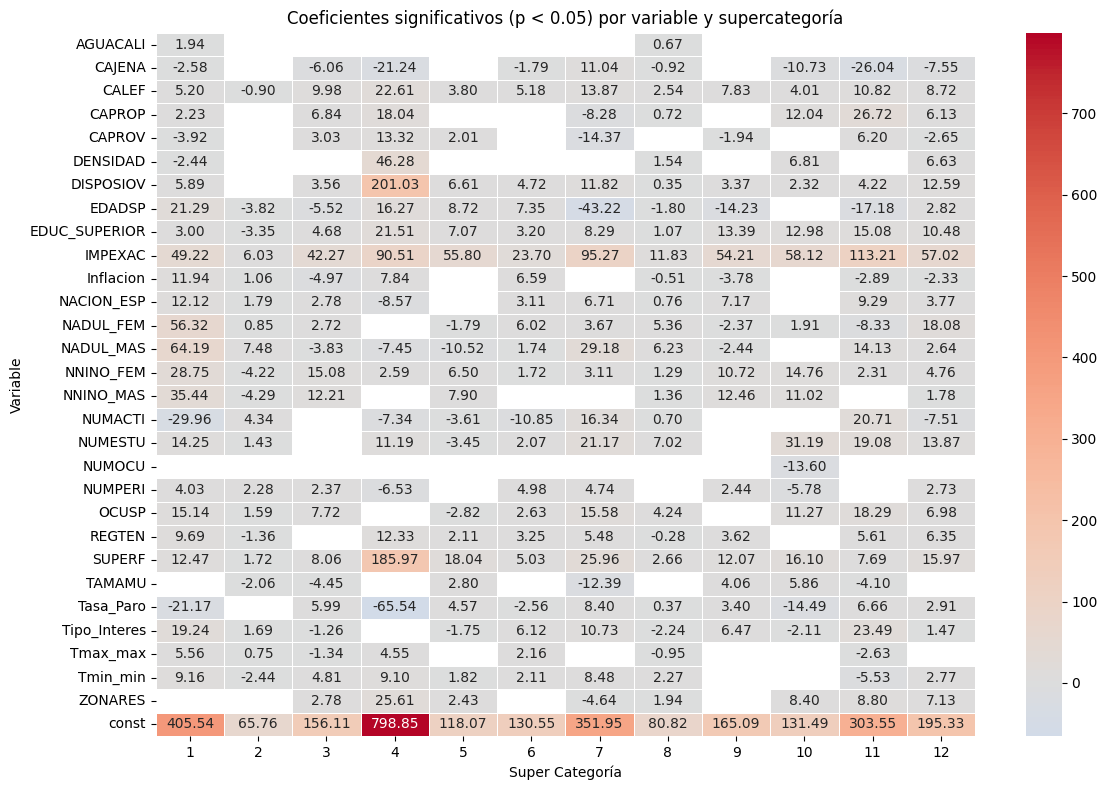

In [29]:
def plot_heatmap_of_coefficients(coefficients_df):
    """
    Muestra un heatmap de los coeficientes significativos por variable y supercategoría.
    """
    summary = coefficients_df.pivot_table(
        index="Variable",
        columns="Super_Categoria",
        values="Coeficiente"
    )

    plt.figure(figsize=(12, 8))
    sns.heatmap(summary, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5)
    plt.title("Coeficientes significativos (p < 0.05) por variable y supercategoría")
    plt.xlabel("Super Categoría")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.show()
plot_heatmap_of_coefficients(coefficients_df)

## 📊 Análisis del Heatmap de Coeficientes Significativos (p < 0.05)
### Contexto
Este análisis se basa en un modelo de regresión lineal múltiple aplicado a cada grupo de gasto del hogar. El heatmap representa los **coeficientes significativos (p < 0.05)** para cada variable explicativa por grupo de gasto. Las variables indican características sociodemográficas o contextuales del hogar.

---

### 🗂 Categorías por código (Super_Categoría)

| Código | Grupo de Gasto |
|--------|----------------|
| 1 | Alimentos y bebidas no alcohólicas |
| 2 | Bebidas alcohólicas, tabaco y narcóticos |
| 3 | Artículos de vestir y calzado |
| 4 | Vivienda, agua, electricidad, gas y otros combustibles |
| 5 | Mobiliario, equipamiento del hogar y gastos de conservación |
| 6 | Salud |
| 7 | Transportes |
| 8 | Comunicaciones |
| 9 | Ocio, espectáculos y cultura |
| 10 | Enseñanza |
| 11 | Hoteles, cafés y restaurantes |
| 12 | Otros bienes y servicios |

---
### 🥦 Grupo 01. Alimentos y bebidas no alcohólicas

- **AGUACALI (51.31)**: Alta relación positiva, más gasto en agua corriente.
- **NACION_ESP (55.13)**: Los hogares de nacionalidad española gastan más en este grupo.
- **NUMESTU (31.87)** y **SEXOSP (18.06)**: Más estudiantes y ser hombre (probablemente) se asocia a mayor gasto en alimentación.
- **DISPOSIOV (17.47)**: Disponibilidad de bienes duraderos también impulsa el gasto.

---

### 🍷 Grupo 02. Bebidas alcohólicas, tabaco y narcóticos

- **EDUC_SUPERIOR (-7.02)**: Contrario a lo esperado, mayor educación parece reducir el gasto en este grupo.
- **DISPOSIOV (8.89)**, **NMIEB (5.12)** y **NUMACTI (8.93)**: Hogares más equipados y con más miembros activos tienden a gastar más.
- **CALEF (-2.48)**: Posible efecto de localización o clima.

---

### 👗 Grupo 03. Artículos de vestir y calzado

- **CALEF (21.17)** y **CAPROP (8.36)**: Tener calefacción o ser propietario se asocia a mayor gasto.
- **EDUC_SUPERIOR (10.43)**, **NMIEB (6.30)** y **NUMESTU (4.79)** también influyen positivamente.
- **NUMACTI (-10.35)**: Más personas activas en el hogar reducen el gasto en ropa (quizá por reutilización o compra más funcional).

---

### 🏠 Grupo 04. Vivienda, agua, electricidad, gas...

- **DISPOSIOV (553.75)**: La más impactante de todo el heatmap. Hogares con bienes duraderos tienen mayor gasto en vivienda.
- **CALEF (53.11)** y **EDUC_SUPERIOR (45.33)** también muestran fuerte impacto positivo.
- **DENSIDAD (-50.45)**: Zonas más densas → menor gasto en vivienda.
- **NACION_ESP (-40.34)**, **REGTEN (-10.63)** y **NUMOCU (-34.19)** también son negativas, quizás por vivir en alquiler o mayor eficiencia de espacio.

---

### 🪑 Grupo 05. Mobiliario, equipamiento y conservación del hogar

- **NUMOCU (45.88)** y **DISPOSIOV (17.67)**: Más ocupantes o bienes duraderos → más gasto en mobiliario.
- **EDUC_SUPERIOR (14.03)** y **NACION_ESP (15.10)** positivos.
- **TOTAL_DEPENDIENTES (5.33)** y **NUMESTU (8.83)**: Más carga familiar implica más inversión en equipamiento.

---

### 🏥 Grupo 06. Salud

- **NMIEB (-7.28)** y **NUMACTI (-10.25)**: Más miembros activos → menos gasto en salud (probablemente por menor necesidad).
- **DISPOSIOV (12.51)**, **EDUC_SUPERIOR (2.67)** y **NACION_ESP (30.02)** influyen positivamente.

---

### 🚗 Grupo 07. Transportes

- **NUMESTU (43.32)**: Altísimo impacto, quizás por uso de transporte escolar o acompañamiento.
- **DISPOSIOV (33.08)**, **EDUC_SUPERIOR (24.08)**, **TRABAJANDO (38.54)**: Todos positivos.
- **REGTEN (-2.95)**: Algunas formas de tenencia reducen el gasto en transporte.

---

### 📞 Grupo 08. Comunicaciones

- **NUMESTU (15.17)**, **NMIEB (10.41)**, **DISPOSIOV (9.01)**: Los hogares con más estudiantes y miembros gastan más en comunicación.
- **EDUC_SUPERIOR (2.60)**, **TRABAJANDO (9.36)**: Impacto positivo también.

---

### 🎭 Grupo 09. Ocio, espectáculos y cultura

- **NUMESTU (44.51)**, **DISPOSIOV (5.43)**, **EDUC_SUPERIOR (28.43)**: Claramente, más nivel educativo y estudiantes → más ocio y cultura.
- **REGTEN (-3.81)**: Ciertas tenencias limitan este tipo de gasto.

---

### 🎓 Grupo 10. Enseñanza

- **NUMESTU (38.99)**, **EDUC_SUPERIOR (36.57)**, **SEXOSP (32.76)**: Fuerte relación positiva, el grupo más coherente con su función.
- **NACION_ESP (41.79)**: Hogares españoles gastan más en educación.

---

### 🍽 Grupo 11. Hoteles, cafés y restaurantes

- **NUMOCU (34.94)**, **NUMESTU (28.62)**, **EDUC_SUPERIOR (21.85)**: Hogares más grandes, con educación superior → más gasto social.
- **DISPOSIOV (9.32)** y **NMIEB (19.65)** también destacan.

---

### 🧴 Grupo 12. Otros bienes y servicios

- **DISPOSIOV (34.79)**, **NUMESTU (28.62)**, **EDUC_SUPERIOR (21.85)**: Hogares con más recursos y estudiantes gastan más en esta categoría.
- **NMIEB (19.65)**, **NACION_ESP (17.22)**: Efecto positivo general.

---


